# Import the necessary libraries


In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
# import seaborn as sns


from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
import warnings

warnings.filterwarnings("ignore")

# Exploring the dataset


## 1. Freezer data


In [492]:
freezer_data_df = pd.read_csv("./dataset/freezer_data.csv")
freezer_data_df.head()

,Freezer Name,Model Number,Volume Capacity (Liters),Power and maitainance Cost (LKR) per 100 hours
0,ChillMaster,M001,55,2500
1,FreezeZone,M002,75,2800
2,CoolTech,M003,120,3200
3,mini CoolTech,M004,30,1800
4,IceBlast Pro,M005,150,3500


So there are 10 types of freezers. We need to cluster the shops and recommend the best freezer for each cluster.


In [493]:
freezer_data_df.shape

(10, 4)

In [494]:
freezer_data_df.head(10)

,Freezer Name,Model Number,Volume Capacity (Liters),Power and maitainance Cost (LKR) per 100 hours
0,ChillMaster,M001,55,2500
1,FreezeZone,M002,75,2800
2,CoolTech,M003,120,3200
3,mini CoolTech,M004,30,1800
4,IceBlast Pro,M005,150,3500
5,IceBlast,M006,65,2700
6,FreezeTech,M007,100,3000
7,FreezeTech 3.0,M008,25,1600
8,ChillTech,M009,80,2800
9,IceTech,M010,200,4500


In [495]:
freezer_data_df.isna().sum()

Freezer Name                                      0
Model Number                                      0
Volume Capacity (Liters)                          0
Power and maitainance Cost (LKR) per 100 hours    0
dtype: int64

## 2. Outlet Area data


In [496]:
outlets_area_df = pd.read_csv("./dataset/outlets_data.csv")
outlets_area_df.head()

,Outlet_ID,area(sqft)
0,ID7203,5660
1,ID1878,4138
2,ID1740,5546
3,ID4366,5134
4,ID8358,4100


In [497]:
outlets_area_df.shape

(988, 2)

In [498]:
outlets_area_df["Outlet_ID"].nunique()

951

In [499]:
# find the duplicated outlets id
# get the duplicated outlets id, and the duplicated rows
duplicated_ids = (
    outlets_area_df[outlets_area_df["Outlet_ID"].duplicated()]["Outlet_ID"]
    .unique()
    .tolist()
)

In [500]:
for dup_id in duplicated_ids:
    print(f"Outlet ID: {dup_id}")
    print(outlets_area_df[outlets_area_df["Outlet_ID"] == dup_id])
    print("-" * 20)

Outlet ID: ID8278
    Outlet_ID  area(sqft)
320    ID8278        3600
384    ID8278        4980
--------------------
Outlet ID: ID8631
    Outlet_ID  area(sqft)
25     ID8631        4024
406    ID8631        3196
--------------------
Outlet ID: ID4003
    Outlet_ID  area(sqft)
77     ID4003        4841
444    ID4003        2990
--------------------
Outlet ID: ID1365
    Outlet_ID  area(sqft)
98     ID1365        5823
494    ID1365        1291
--------------------
Outlet ID: ID2170
    Outlet_ID  area(sqft)
310    ID2170        8077
525    ID2170        6169
--------------------
Outlet ID: ID1485
    Outlet_ID  area(sqft)
292    ID1485        4535
537    ID1485        9483
--------------------
Outlet ID: ID9465
    Outlet_ID  area(sqft)
441    ID9465        1583
563    ID9465        6650
--------------------
Outlet ID: ID6214
    Outlet_ID  area(sqft)
232    ID6214        1608
564    ID6214        4052
--------------------
Outlet ID: ID3549
    Outlet_ID  area(sqft)
415    ID3549       

In [501]:
outlets_area_df.isna().sum()

Outlet_ID     0
area(sqft)    0
dtype: int64

## 3. Product data


In [502]:
product_data_df = pd.read_csv("./dataset/product_data.csv")
product_data_df.head()

,pid,volume,product_name,price
0,IP1,0.2,Vanilla Mini Cone,100
1,IP2,0.2,Chocolate Petite Bar,90
2,IP3,0.2,Strawberry Tiny Cup,110
3,IP4,0.2,Mint Bite-size Pop,100
4,IP5,0.2,Butter Pecan Small Stick,100


In [503]:
product_data_df.shape

(10, 4)

In [504]:
product_data_df.head(10)

,pid,volume,product_name,price
0,IP1,0.2,Vanilla Mini Cone,100
1,IP2,0.2,Chocolate Petite Bar,90
2,IP3,0.2,Strawberry Tiny Cup,110
3,IP4,0.2,Mint Bite-size Pop,100
4,IP5,0.2,Butter Pecan Small Stick,100
5,BP1,1.0,Chocolate Fudge Big Scoop,1200
6,BP2,1.0,Moose Tracks Jumbo Cup,1100
7,BP3,1.0,Mint Chocolate Chip Family Pack,1150
8,BP4,1.0,Rocky Road Mega Tub,1000
9,BP5,1.0,Cookies and Cream Mega Tub,1100


In [505]:
product_data_df.isna().sum()

pid             0
volume          0
product_name    0
price           0
dtype: int64

## 4. Sales data


In [506]:
sales_data_df = pd.read_csv("./dataset/sales_data.csv")
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units
0,ID7203,1,IP1,Vanilla Mini Cone,874.0
1,ID7203,1,IP2,Chocolate Petite Bar,105.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0
3,ID7203,1,IP4,Mint Bite-size Pop,502.0
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0


In [507]:
sales_data_df.shape

(81000, 5)

In [508]:
sales_data_df["Outlet_ID"].nunique()

951

In [509]:
sales_data_df["product_name"].nunique()

10

In [510]:
sales_data_df["week"].nunique()

12

In [511]:
sales_data_df.describe()

,week,no_units
count,81000.000000,81000.000000
mean,6.504432,373.143543
std,3.453426,370.546966
min,1.000000,20.000000
25%,4.000000,79.000000
50%,7.000000,210.000000
75%,10.000000,593.000000
max,12.000000,1499.000000


In [512]:
sales_data_df.isna().sum()

Outlet_ID       0
week            0
pid             0
product_name    0
no_units        0
dtype: int64

## 5. Week data


In [513]:
week_data_df = pd.read_csv("./dataset/week_data.csv")
week_data_df.head()

,Week,Start Date,End Date
0,Week 1,1/2/2023,1/8/2023
1,Week 2,1/9/2023,1/15/2023
2,Week 3,1/16/2023,1/22/2023
3,Week 4,1/23/2023,1/29/2023
4,Week 5,1/30/2023,2/5/2023


In [514]:
week_data_df.shape

(12, 3)

In [515]:
week_data_df.head(12)

,Week,Start Date,End Date
0,Week 1,1/2/2023,1/8/2023
1,Week 2,1/9/2023,1/15/2023
2,Week 3,1/16/2023,1/22/2023
3,Week 4,1/23/2023,1/29/2023
4,Week 5,1/30/2023,2/5/2023
5,Week 6,2/6/2023,2/12/2023
6,Week 7,2/13/2023,2/19/2023
7,Week 8,2/20/2023,2/26/2023
8,Week 9,2/27/2023,3/5/2023
9,Week 10,3/6/2023,3/12/2023


Converting to the number to join with the sales data


In [516]:
week_data_df["week"] = week_data_df["Week"].str.replace("Week ", "").astype(int)

In [517]:
week_data_df.drop("Week", axis=1, inplace=True)

### Note:


We do have the data for three months <br>
We have weekly sales details as well. <br>


Extract the day and the month from the date and add it to the sales data. <br>
Then we can merge it with our own dataframes. <br>


There are some special days in these three months. <br>

-   1st Jan 2023
-   15th Jan 2023
-   14th Feb 2023


### Extracting the day and the month from the date


In [518]:
week_data_df.dtypes

Start Date    object
End Date      object
week           int32
dtype: object

In [519]:
week_data_df["Start Date"] = pd.to_datetime(week_data_df["Start Date"])

In [520]:
# convert the 'End Date' column to a datetime format
week_data_df["End Date"] = pd.to_datetime(week_data_df["End Date"])

# extract the week of the transaction and store it in a new column
week_data_df["month_of_transaction"] = week_data_df["End Date"].dt.month

week_data_df.head()

,Start Date,End Date,week,month_of_transaction
0,2023-01-02,2023-01-08,1,1
1,2023-01-09,2023-01-15,2,1
2,2023-01-16,2023-01-22,3,1
3,2023-01-23,2023-01-29,4,1
4,2023-01-30,2023-02-05,5,2


# Compiling and extracting information from the datasets


## Dataframe with unique outlet id's


In [521]:
sales_data_df["Outlet_ID"].nunique()

951

In [522]:
# create a dataframe with one column containing all the unique outlet ids
outlet_info_df = pd.DataFrame(
    sales_data_df["Outlet_ID"].unique(), columns=["Outlet_ID"]
)
outlet_info_df.head()

,Outlet_ID
0,ID7203
1,ID1878
2,ID1740
3,ID4366
4,ID8358


In [523]:
outlet_info_df.shape

(951, 1)

## Extracting info form the other datasets


We have the following dataframes now:

-   freezer_data_df : Freezer data (10 unique freezers)
-   outlets_area_df : Area of each outlet (there are 37 duplicates!!) & contains -> [outlet_id, area]
-   product_data_df : Product data (10 unique products) & contains -> [pid, volume, product_name, price]
-   sales_data_df : Sales data (contains 3 months data) & contains -> ['Outlet_ID', 'week', 'pid', 'product_name', 'no_units']
-   week_data_df : Information on 12 weeks & contains -> ['Start Date', 'End Date', 'week', 'month_of_transaction']


### Merging the dataframes


In [524]:
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units
0,ID7203,1,IP1,Vanilla Mini Cone,874.0
1,ID7203,1,IP2,Chocolate Petite Bar,105.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0
3,ID7203,1,IP4,Mint Bite-size Pop,502.0
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0


In [525]:
sales_data_df[["pid", "product_name"]].nunique()

pid             10
product_name    10
dtype: int64

In [526]:
# join the product data price and volume colume to sales_data_df
sales_data_df = sales_data_df.merge(
    product_data_df[["product_name", "price", "volume"]], on="product_name", how="left"
)
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units,price,volume
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,100,0.2
1,ID7203,1,IP2,Chocolate Petite Bar,105.0,90,0.2
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0,110,0.2
3,ID7203,1,IP4,Mint Bite-size Pop,502.0,100,0.2
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0,100,0.2


In [527]:
sales_data_df = sales_data_df.merge(
    week_data_df[["Start Date", "End Date", "week", "month_of_transaction"]],
    on="week",
    how="left",
)
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units,price,volume,Start Date,End Date,month_of_transaction
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,100,0.2,2023-01-02,2023-01-08,1
1,ID7203,1,IP2,Chocolate Petite Bar,105.0,90,0.2,2023-01-02,2023-01-08,1
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0,110,0.2,2023-01-02,2023-01-08,1
3,ID7203,1,IP4,Mint Bite-size Pop,502.0,100,0.2,2023-01-02,2023-01-08,1
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0,100,0.2,2023-01-02,2023-01-08,1


### Note:


At this point we have the following dataframes:

-   sales_data_df
-   outlets_area_df
-   freezer_data_df


outlets_area_df has 37 duplicates. We need to remove them. <br>
Since, we don't which one to remove, yet we will keep all of them. <br>
We can make the decision once we have the final dataframe. <br>
<br>
For the Freezer_data_df it contains the freezers and its information. So we have to assign a freezer to a shop at last. Clusster the shops into 10 categories and assign the freezer to each cluster. <br>


## Creating more features in the sales_data_df


### Get total earnings per row


In [528]:
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units,price,volume,Start Date,End Date,month_of_transaction
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,100,0.2,2023-01-02,2023-01-08,1
1,ID7203,1,IP2,Chocolate Petite Bar,105.0,90,0.2,2023-01-02,2023-01-08,1
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0,110,0.2,2023-01-02,2023-01-08,1
3,ID7203,1,IP4,Mint Bite-size Pop,502.0,100,0.2,2023-01-02,2023-01-08,1
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0,100,0.2,2023-01-02,2023-01-08,1


In [529]:
sales_data_df["total_earning"] = sales_data_df["price"] * sales_data_df["no_units"]
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units,price,volume,Start Date,End Date,month_of_transaction,total_earning
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,100,0.2,2023-01-02,2023-01-08,1,87400.0
1,ID7203,1,IP2,Chocolate Petite Bar,105.0,90,0.2,2023-01-02,2023-01-08,1,9450.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0,110,0.2,2023-01-02,2023-01-08,1,131780.0
3,ID7203,1,IP4,Mint Bite-size Pop,502.0,100,0.2,2023-01-02,2023-01-08,1,50200.0
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0,100,0.2,2023-01-02,2023-01-08,1,71000.0


### Get total volume sold per row


In [530]:
sales_data_df["total_volume_sold"] = sales_data_df["volume"] * sales_data_df["no_units"]
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units,price,volume,Start Date,End Date,month_of_transaction,total_earning,total_volume_sold
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,100,0.2,2023-01-02,2023-01-08,1,87400.0,174.8
1,ID7203,1,IP2,Chocolate Petite Bar,105.0,90,0.2,2023-01-02,2023-01-08,1,9450.0,21.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0,110,0.2,2023-01-02,2023-01-08,1,131780.0,239.6
3,ID7203,1,IP4,Mint Bite-size Pop,502.0,100,0.2,2023-01-02,2023-01-08,1,50200.0,100.4
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0,100,0.2,2023-01-02,2023-01-08,1,71000.0,142.0


## Adding new features to the final dataframe


In [531]:
outlet_info_df.head()

,Outlet_ID
0,ID7203
1,ID1878
2,ID1740
3,ID4366
4,ID8358


In [532]:
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units,price,volume,Start Date,End Date,month_of_transaction,total_earning,total_volume_sold
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,100,0.2,2023-01-02,2023-01-08,1,87400.0,174.8
1,ID7203,1,IP2,Chocolate Petite Bar,105.0,90,0.2,2023-01-02,2023-01-08,1,9450.0,21.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0,110,0.2,2023-01-02,2023-01-08,1,131780.0,239.6
3,ID7203,1,IP4,Mint Bite-size Pop,502.0,100,0.2,2023-01-02,2023-01-08,1,50200.0,100.4
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0,100,0.2,2023-01-02,2023-01-08,1,71000.0,142.0


### 1. Units sold per week


In [533]:
# group by Outlet_ID and week, and get the sum of no_units sold per week
weekly_sales_df = (
    sales_data_df.groupby(["Outlet_ID", "week"])["no_units"].sum().reset_index()
)
weekly_sales_df.head()

,Outlet_ID,week,no_units
0,ID1008,1,3990.0
1,ID1008,2,3293.0
2,ID1008,3,3590.0
3,ID1008,4,2691.0
4,ID1008,5,1522.0


In [534]:
# for each shop plot the no_units sold per week
# for outlet_id in weekly_sales_df["Outlet_ID"].unique():
#     outlet_weekly_sales_df = weekly_sales_df[weekly_sales_df["Outlet_ID"] == outlet_id]
#     plt.figure(figsize=(15, 5))
#     plt.plot(outlet_weekly_sales_df["week"], outlet_weekly_sales_df["no_units"])
#     plt.title(f"Outlet ID: {outlet_id}")
#     plt.xlabel("Week")
#     plt.ylabel("No. of units sold")
#     plt.show()

In [535]:
for week in range(1, 13):
    week_sales_df = weekly_sales_df[weekly_sales_df["week"] == week].reset_index(
        drop=True
    )
    week_sales_df.drop("week", axis=1, inplace=True)

    week_sales_df.rename(columns={"no_units": f"weekly_sale_for_{week}"}, inplace=True)
    # merge the week_sales_df with outlet_info_df
    outlet_info_df = outlet_info_df.merge(week_sales_df, on="Outlet_ID", how="left")

In [536]:
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,weekly_sale_for_10,weekly_sale_for_11,weekly_sale_for_12
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,2484.0,4382.0,2233.0
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,3961.0,2210.0,2469.0
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,3081.0,3693.0,3067.0
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,4975.0,2426.0,3579.0
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,2831.0,2338.0,4071.0


### 2. Total volume sold per week


In [537]:
weekly_volume_df = (
    sales_data_df.groupby(["Outlet_ID", "week"])["total_volume_sold"]
    .sum()
    .reset_index()
)
weekly_volume_df.head()

,Outlet_ID,week,total_volume_sold
0,ID1008,1,798.0
1,ID1008,2,658.6
2,ID1008,3,718.0
3,ID1008,4,538.2
4,ID1008,5,304.4


In [538]:
for week in range(1, 13):
    week_vol_df = weekly_volume_df[weekly_volume_df["week"] == week].reset_index(
        drop=True
    )
    week_vol_df.drop("week", axis=1, inplace=True)

    week_vol_df.rename(
        columns={"total_volume_sold": f"weekly_sold_volume_for_{week}"}, inplace=True
    )
    # merge the week_vol_df with outlet_info_df
    outlet_info_df = outlet_info_df.merge(week_vol_df, on="Outlet_ID", how="left")

In [539]:
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,weekly_sold_volume_for_3,weekly_sold_volume_for_4,weekly_sold_volume_for_5,weekly_sold_volume_for_6,weekly_sold_volume_for_7,weekly_sold_volume_for_8,weekly_sold_volume_for_9,weekly_sold_volume_for_10,weekly_sold_volume_for_11,weekly_sold_volume_for_12
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,561.0,516.6,560.4,645.4,598.4,627.6,461.8,496.8,876.4,446.6
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,561.8,744.8,642.6,662.6,576.6,700.2,662.4,792.2,442.0,493.8
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,740.4,612.0,764.4,638.0,427.6,562.4,414.4,616.2,738.6,613.4
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,768.6,807.2,465.6,490.8,636.2,605.0,795.0,995.0,485.2,715.8
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,686.6,910.4,216.0,719.6,632.8,699.4,747.6,566.2,467.6,814.2


### 3. Total earnings per week


In [540]:
weekly_earning_df = (
    sales_data_df.groupby(["Outlet_ID", "week"])["total_earning"].sum().reset_index()
)
weekly_earning_df.head()

,Outlet_ID,week,total_earning
0,ID1008,1,397290.0
1,ID1008,2,332330.0
2,ID1008,3,362450.0
3,ID1008,4,273290.0
4,ID1008,5,155790.0


In [541]:
for week in range(1, 13):
    week_earning_df = weekly_earning_df[weekly_earning_df["week"] == week].reset_index(
        drop=True
    )
    week_earning_df.drop("week", axis=1, inplace=True)

    week_earning_df.rename(
        columns={"total_earning": f"weekly_earning_for_{week}"}, inplace=True
    )
    # merge the week_earning_df with outlet_info_df
    outlet_info_df = outlet_info_df.merge(week_earning_df, on="Outlet_ID", how="left")

In [542]:
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,weekly_earning_for_3,weekly_earning_for_4,weekly_earning_for_5,weekly_earning_for_6,weekly_earning_for_7,weekly_earning_for_8,weekly_earning_for_9,weekly_earning_for_10,weekly_earning_for_11,weekly_earning_for_12
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,275200.0,259650.0,271830.0,327390.0,301010.0,320700.0,227830.0,241650.0,437660.0,231560.0
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,282580.0,379070.0,322280.0,330430.0,277250.0,350880.0,330170.0,401670.0,225080.0,237880.0
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,369650.0,300560.0,385470.0,316730.0,215310.0,277610.0,211340.0,312190.0,370450.0,303370.0
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,383500.0,404840.0,224220.0,254280.0,321540.0,300490.0,408690.0,497280.0,243100.0,362090.0
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,340710.0,454070.0,101010.0,354670.0,309570.0,347220.0,383510.0,282780.0,233040.0,403370.0


### 4. No of units sold for each product


In [543]:
feature_cnt_df = (
    sales_data_df.groupby(["Outlet_ID", "product_name"])["no_units"].sum().reset_index()
)
feature_cnt_df.head()

,Outlet_ID,product_name,no_units
0,ID1008,Butter Pecan Small Stick,6055.0
1,ID1008,Chocolate Petite Bar,7206.0
2,ID1008,Mint Bite-size Pop,6486.0
3,ID1008,Strawberry Tiny Cup,6285.0
4,ID1008,Vanilla Mini Cone,6970.0


In [544]:
for product in feature_cnt_df["product_name"].unique():
    product_df = feature_cnt_df[feature_cnt_df["product_name"] == product].reset_index(
        drop=True
    )
    product_df.drop("product_name", axis=1, inplace=True)
    product_df.rename(columns={"no_units": f"{product}_units_sold"}, inplace=True)
    outlet_info_df = outlet_info_df.merge(product_df, on="Outlet_ID", how="left")

In [545]:
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Butter Pecan Small Stick_units_sold,Chocolate Petite Bar_units_sold,Mint Bite-size Pop_units_sold,Strawberry Tiny Cup_units_sold,Vanilla Mini Cone_units_sold,Chocolate Fudge Big Scoop_units_sold,Cookies and Cream Mega Tub_units_sold,Mint Chocolate Chip Family Pack_units_sold,Moose Tracks Jumbo Cup_units_sold,Rocky Road Mega Tub_units_sold
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,6443.0,7295.0,5520.0,9127.0,6361.0,NaN,NaN,NaN,NaN,NaN
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,6748.0,6622.0,7954.0,6856.0,7860.0,NaN,NaN,NaN,NaN,NaN
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,6817.0,8116.0,7192.0,7837.0,7625.0,NaN,NaN,NaN,NaN,NaN
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,9524.0,6259.0,8759.0,9232.0,6530.0,NaN,NaN,NaN,NaN,NaN
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,8866.0,9562.0,6241.0,7652.0,7057.0,NaN,NaN,NaN,NaN,NaN


In [546]:
# fill the missing values with 0
outlet_info_df.fillna(0, inplace=True)
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Butter Pecan Small Stick_units_sold,Chocolate Petite Bar_units_sold,Mint Bite-size Pop_units_sold,Strawberry Tiny Cup_units_sold,Vanilla Mini Cone_units_sold,Chocolate Fudge Big Scoop_units_sold,Cookies and Cream Mega Tub_units_sold,Mint Chocolate Chip Family Pack_units_sold,Moose Tracks Jumbo Cup_units_sold,Rocky Road Mega Tub_units_sold
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,6443.0,7295.0,5520.0,9127.0,6361.0,0.0,0.0,0.0,0.0,0.0
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,6748.0,6622.0,7954.0,6856.0,7860.0,0.0,0.0,0.0,0.0,0.0
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,6817.0,8116.0,7192.0,7837.0,7625.0,0.0,0.0,0.0,0.0,0.0
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,9524.0,6259.0,8759.0,9232.0,6530.0,0.0,0.0,0.0,0.0,0.0
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,8866.0,9562.0,6241.0,7652.0,7057.0,0.0,0.0,0.0,0.0,0.0


### 5. Total volume sold for each product


In [547]:
feature_vol_df = (
    sales_data_df.groupby(["Outlet_ID", "product_name"])["total_volume_sold"]
    .sum()
    .reset_index()
)
feature_vol_df.head()

,Outlet_ID,product_name,total_volume_sold
0,ID1008,Butter Pecan Small Stick,1211.0
1,ID1008,Chocolate Petite Bar,1441.2
2,ID1008,Mint Bite-size Pop,1297.2
3,ID1008,Strawberry Tiny Cup,1257.0
4,ID1008,Vanilla Mini Cone,1394.0


In [548]:
for product in feature_vol_df["product_name"].unique():
    product_df = feature_vol_df[feature_vol_df["product_name"] == product].reset_index(
        drop=True
    )
    product_df.drop("product_name", axis=1, inplace=True)
    product_df.rename(
        columns={"total_volume_sold": f"{product}_volume_sold"}, inplace=True
    )
    outlet_info_df = outlet_info_df.merge(product_df, on="Outlet_ID", how="left")

In [549]:
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Butter Pecan Small Stick_volume_sold,Chocolate Petite Bar_volume_sold,Mint Bite-size Pop_volume_sold,Strawberry Tiny Cup_volume_sold,Vanilla Mini Cone_volume_sold,Chocolate Fudge Big Scoop_volume_sold,Cookies and Cream Mega Tub_volume_sold,Mint Chocolate Chip Family Pack_volume_sold,Moose Tracks Jumbo Cup_volume_sold,Rocky Road Mega Tub_volume_sold
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,1288.6,1459.0,1104.0,1825.4,1272.2,NaN,NaN,NaN,NaN,NaN
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,1349.6,1324.4,1590.8,1371.2,1572.0,NaN,NaN,NaN,NaN,NaN
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,1363.4,1623.2,1438.4,1567.4,1525.0,NaN,NaN,NaN,NaN,NaN
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,1904.8,1251.8,1751.8,1846.4,1306.0,NaN,NaN,NaN,NaN,NaN
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,1773.2,1912.4,1248.2,1530.4,1411.4,NaN,NaN,NaN,NaN,NaN


In [550]:
outlet_info_df.fillna(0, inplace=True)
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Butter Pecan Small Stick_volume_sold,Chocolate Petite Bar_volume_sold,Mint Bite-size Pop_volume_sold,Strawberry Tiny Cup_volume_sold,Vanilla Mini Cone_volume_sold,Chocolate Fudge Big Scoop_volume_sold,Cookies and Cream Mega Tub_volume_sold,Mint Chocolate Chip Family Pack_volume_sold,Moose Tracks Jumbo Cup_volume_sold,Rocky Road Mega Tub_volume_sold
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,1288.6,1459.0,1104.0,1825.4,1272.2,0.0,0.0,0.0,0.0,0.0
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,1349.6,1324.4,1590.8,1371.2,1572.0,0.0,0.0,0.0,0.0,0.0
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,1363.4,1623.2,1438.4,1567.4,1525.0,0.0,0.0,0.0,0.0,0.0
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,1904.8,1251.8,1751.8,1846.4,1306.0,0.0,0.0,0.0,0.0,0.0
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,1773.2,1912.4,1248.2,1530.4,1411.4,0.0,0.0,0.0,0.0,0.0


### 6. Total earnings for each product


In [551]:
feature_earn_df = (
    sales_data_df.groupby(["Outlet_ID", "product_name"])["total_earning"]
    .sum()
    .reset_index()
)
feature_earn_df.head()

,Outlet_ID,product_name,total_earning
0,ID1008,Butter Pecan Small Stick,605500.0
1,ID1008,Chocolate Petite Bar,648540.0
2,ID1008,Mint Bite-size Pop,648600.0
3,ID1008,Strawberry Tiny Cup,691350.0
4,ID1008,Vanilla Mini Cone,697000.0


In [552]:
for product in feature_earn_df["product_name"].unique():
    product_df = feature_earn_df[
        feature_earn_df["product_name"] == product
    ].reset_index(drop=True)
    product_df.drop("product_name", axis=1, inplace=True)
    product_df.rename(columns={"total_earning": f"{product}_earning"}, inplace=True)
    outlet_info_df = outlet_info_df.merge(product_df, on="Outlet_ID", how="left")

In [553]:
outlet_info_df.fillna(0, inplace=True)
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Butter Pecan Small Stick_earning,Chocolate Petite Bar_earning,Mint Bite-size Pop_earning,Strawberry Tiny Cup_earning,Vanilla Mini Cone_earning,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,644300.0,656550.0,552000.0,1003970.0,636100.0,0.0,0.0,0.0,0.0,0.0
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,674800.0,595980.0,795400.0,754160.0,786000.0,0.0,0.0,0.0,0.0,0.0
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,681700.0,730440.0,719200.0,862070.0,762500.0,0.0,0.0,0.0,0.0,0.0
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,952400.0,563310.0,875900.0,1015520.0,653000.0,0.0,0.0,0.0,0.0,0.0
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,886600.0,860580.0,624100.0,841720.0,705700.0,0.0,0.0,0.0,0.0,0.0


# Reducing the number of features


## PCA


In [554]:
pca_process_df = outlet_info_df.copy(deep=True)
pca_process_df.drop(["Outlet_ID"], axis=1, inplace=True)
pca_process_df.dtypes

weekly_sale_for_1                          float64
weekly_sale_for_2                          float64
weekly_sale_for_3                          float64
weekly_sale_for_4                          float64
weekly_sale_for_5                          float64
                                            ...   
Chocolate Fudge Big Scoop_earning          float64
Cookies and Cream Mega Tub_earning         float64
Mint Chocolate Chip Family Pack_earning    float64
Moose Tracks Jumbo Cup_earning             float64
Rocky Road Mega Tub_earning                float64
Length: 66, dtype: object

In [555]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(pca_process_df)

cov_matrix = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and eigenvectors in descending order
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Select the top k eigenvectors
k = 10
topk_eigvecs = np.array([eig_pairs[i][1] for i in range(k)])

X_reduced = X_std.dot(topk_eigvecs.T)

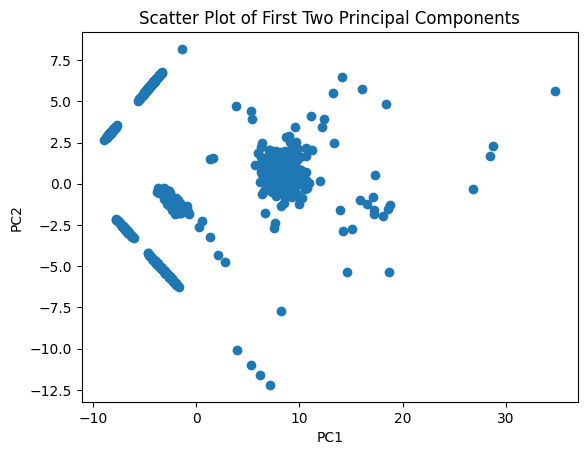

In [556]:
pc1 = X_reduced[:, 0]
pc2 = X_reduced[:, 1]

# Create a scatter plot of the first two principal components
plt.scatter(pc1, pc2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot of First Two Principal Components")
plt.show()

## PCA with sklearn


In [557]:
from sklearn.decomposition import PCA

# Assuming your data is stored in a numpy array X with shape (n_samples, n_features)
# Create a PCA object with 7 components
pca = PCA(n_components=7)

X = pca_process_df.values

# Fit the PCA model to the data
pca.fit(X)

# Transform the data to its low-dimensional representation
X_reduced = pca.transform(X)

## PCA with sklearn (2 components)


In [558]:
from sklearn.decomposition import PCA

# Assuming your data is stored in a numpy array X with shape (n_samples, n_features)
# Create a PCA object with 2 components
pca = PCA(n_components=2)

X = pca_process_df.values

# Fit the PCA model to the data
pca.fit(X)

# Transform the data to its low-dimensional representation
X_reduced_two = pca.transform(X)

## Scaling and PCA


In [559]:
# Scale with robust scaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X = scaler.fit_transform(pca_process_df)

# Fit the PCA model to the data
pca = PCA(n_components=3)
pca.fit(X)

X_reduced_three = pca.transform(X)

In [560]:
scaler = RobustScaler()
X = scaler.fit_transform(pca_process_df)

# Fit the PCA model to the data
pca = PCA(n_components=5)
pca.fit(X)

X_reduced_five = pca.transform(X)

In [561]:
scaler = RobustScaler()
X = scaler.fit_transform(pca_process_df)

# Fit the PCA model to the data
pca = PCA(n_components=2)
pca.fit(X)

X_reduced_robust_two = pca.transform(X)

## Scaling with StandardScaler and PCA


In [562]:
# scale with standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(pca_process_df)

pca = PCA(n_components=2)
pca.fit(X)

X_reduced_scaled_standard = pca.transform(X)

# Trying out different Models to Cluster


Evaluation metrics


In [563]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

-   Inertia - Inertia is the sum of squared distances of samples to their closest
    cluster center. A good model is one with low inertia AND a low number of
    clusters (K).
-   Silhouette Coefficient - Silhouette score for a set of sample data points is used
    to measure how dense and well-separated the clusters are. The silhouette score
    of 1 means that the clusters are very dense and nicely separated. The score of 0
    means that clusters are overlapping. The score of less than 0 means that data
    belonging to clusters may be wrong/incorrect.
-   Davies-Bouldin Index - Davies Bouldin index is based on the principle of with-
    cluster and between cluster distances. It is commonly used for deciding the
    number of clusters in which the data points should be labeled. It is different from the other two as the value of this index should be small. So, the main motive is to
    decrease the DB index.
-   Calinski-Harabasz Index - The Calinski Harabaz index is based on the principle
    of variance ratio. This ratio is calculated between two parameters within-cluster
    diffusion and between cluster dispersion. The higher the index the better it is
    clustering


In [564]:
X_mag = np.abs(X_reduced)

## KMeans


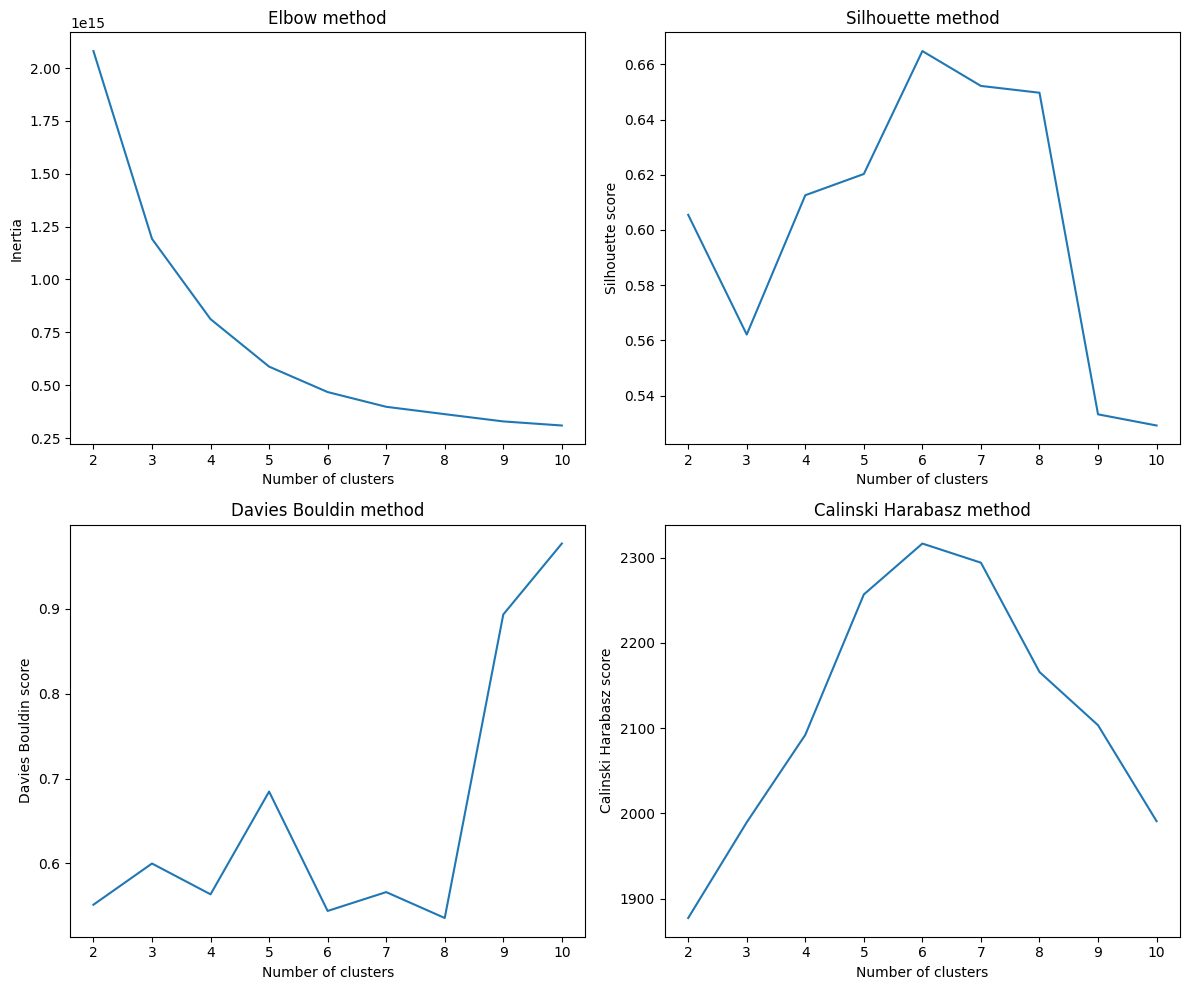

In [565]:
# import KMeans from sklearn
from sklearn.cluster import KMeans

inertia = []
labels_ = []
silhouette_scores = []
db_scores = []
ch_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=30).fit(X_reduced)
    labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_reduced, labels))
    db_scores.append(davies_bouldin_score(X_reduced, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced, labels))
    labels_.append(labels)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Elbow method plot
axs[0, 0].plot(range(2, 11), inertia)
axs[0, 0].set_title("Elbow method")
axs[0, 0].set_xlabel("Number of clusters")
axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), silhouette_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

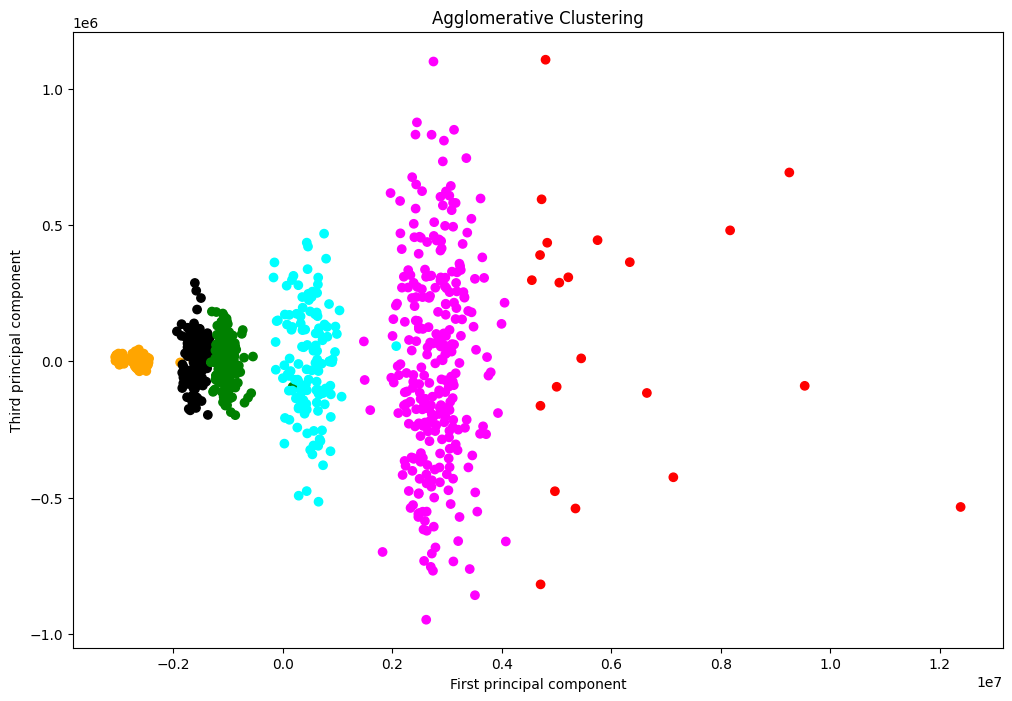

In [566]:
colors = ["red", "green", "cyan", "orange", "magenta", "black"]

# Create a scatter plot with custom colors for each cluster
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 2],
    c=[colors[label] for label in labels_[4]],
    cmap="plasma",
)
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Third principal component")
plt.show()

## KMedoids


### With PCA


In [567]:
from sklearn_extra.cluster import KMedoids

inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []

for i in range(2, 11):
    kmedoids = KMedoids(n_clusters=i, random_state=0).fit(X_mag)
    labels = kmedoids.labels_
    inertia.append(kmedoids.inertia_)
    silhouette_scores.append(silhouette_score(X_mag, labels))
    db_scores.append(davies_bouldin_score(X_mag, labels))
    ch_scores.append(calinski_harabasz_score(X_mag, labels))

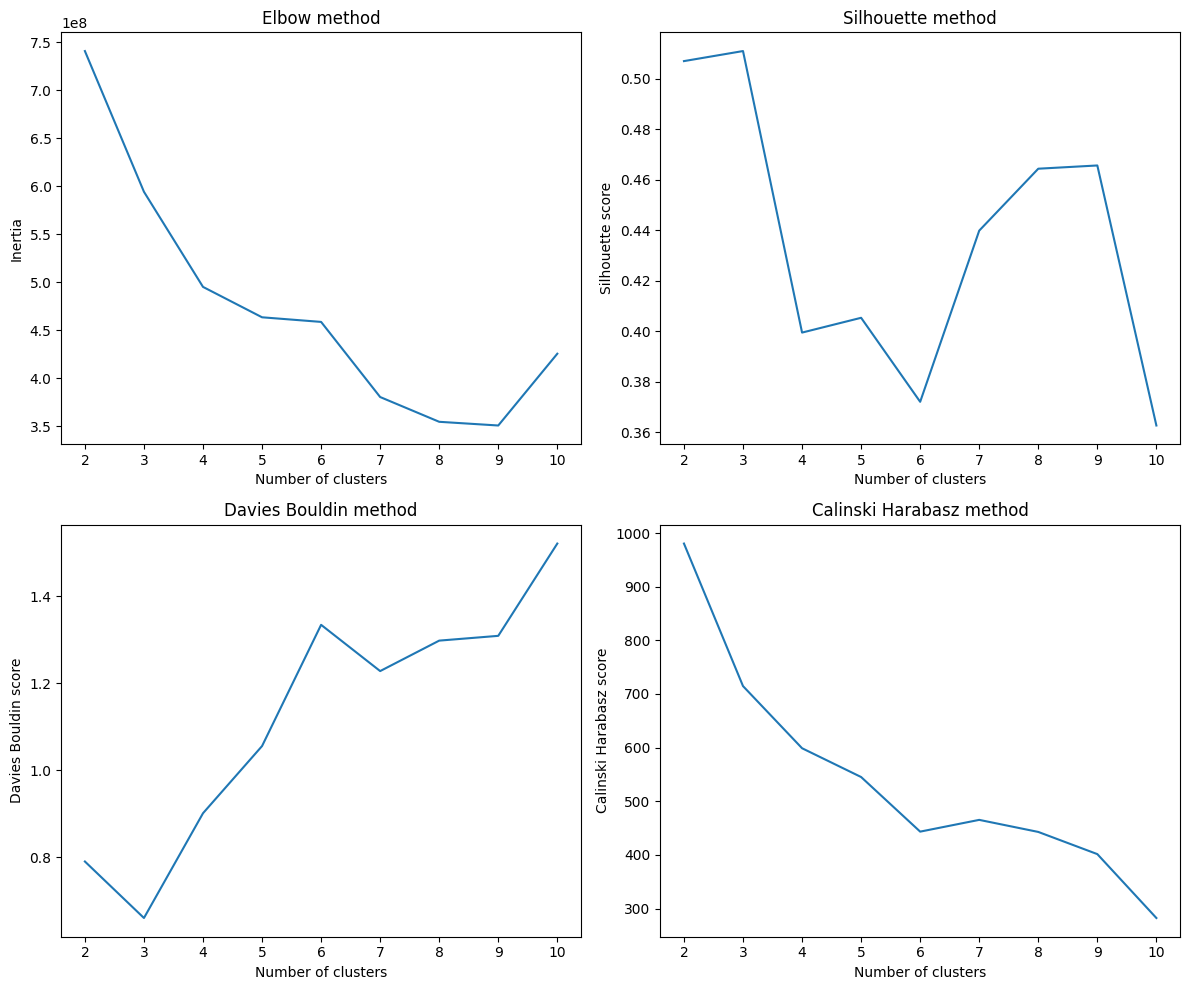

In [568]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Elbow method plot
axs[0, 0].plot(range(2, 11), inertia)
axs[0, 0].set_title("Elbow method")
axs[0, 0].set_xlabel("Number of clusters")
axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), silhouette_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

### Without PCA


In [569]:
inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []

for i in range(2, 11):
    kmedoids = KMedoids(n_clusters=i, random_state=0).fit(X_std)
    labels = kmedoids.labels_
    inertia.append(kmedoids.inertia_)
    silhouette_scores.append(silhouette_score(X_std, labels))
    db_scores.append(davies_bouldin_score(X_std, labels))
    ch_scores.append(calinski_harabasz_score(X_std, labels))

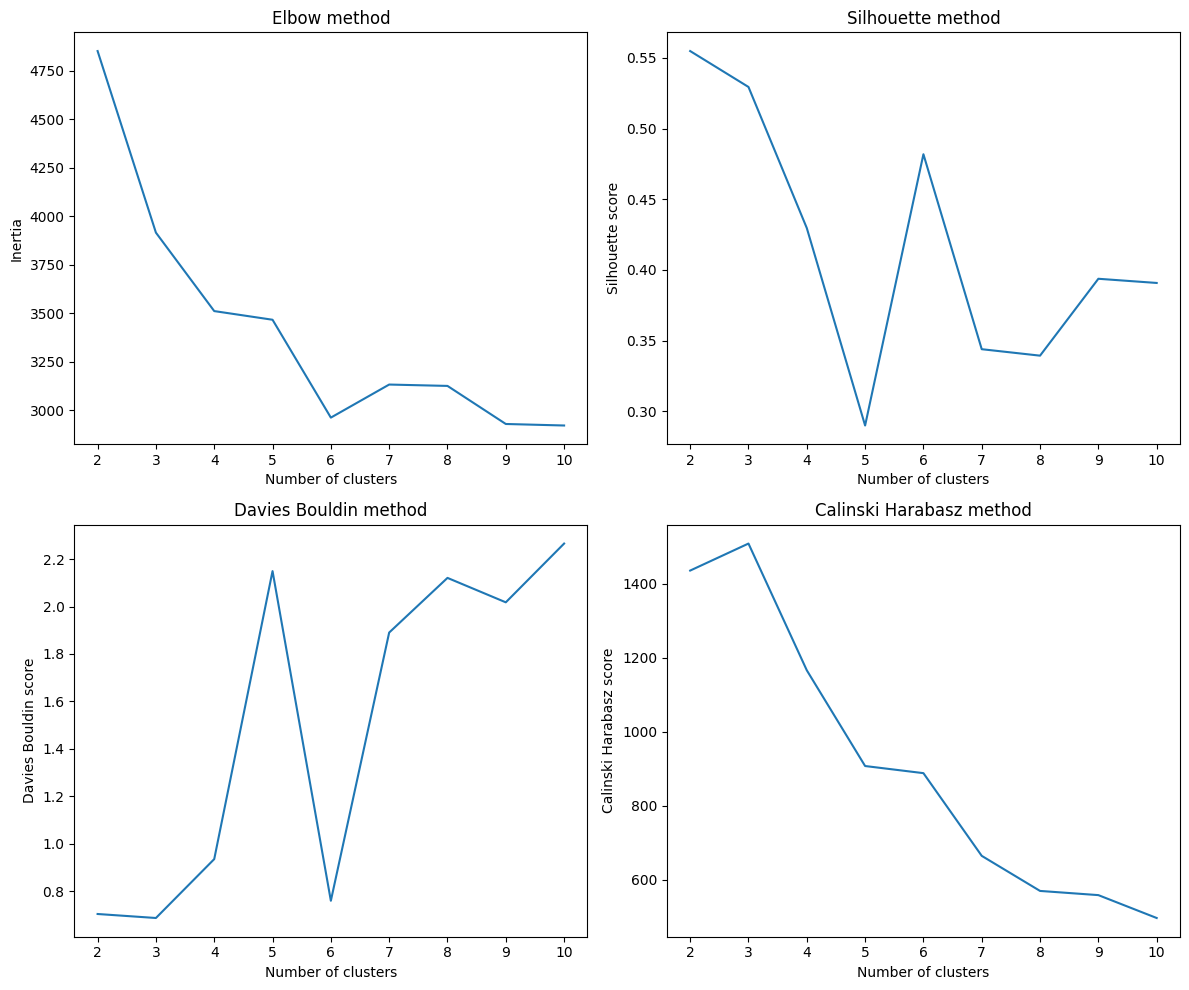

In [570]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Elbow method plot
axs[0, 0].plot(range(2, 11), inertia)
axs[0, 0].set_title("Elbow method")
axs[0, 0].set_xlabel("Number of clusters")
axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), silhouette_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

### PCA with sklearn


In [571]:
inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []
labels_ = []

for i in range(2, 11):
    kmedoids = KMedoids(n_clusters=i, random_state=0).fit(X_reduced)
    labels = kmedoids.labels_
    inertia.append(kmedoids.inertia_)
    silhouette_scores.append(silhouette_score(X_reduced, labels))
    db_scores.append(davies_bouldin_score(X_reduced, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced, labels))
    labels_.append(labels)

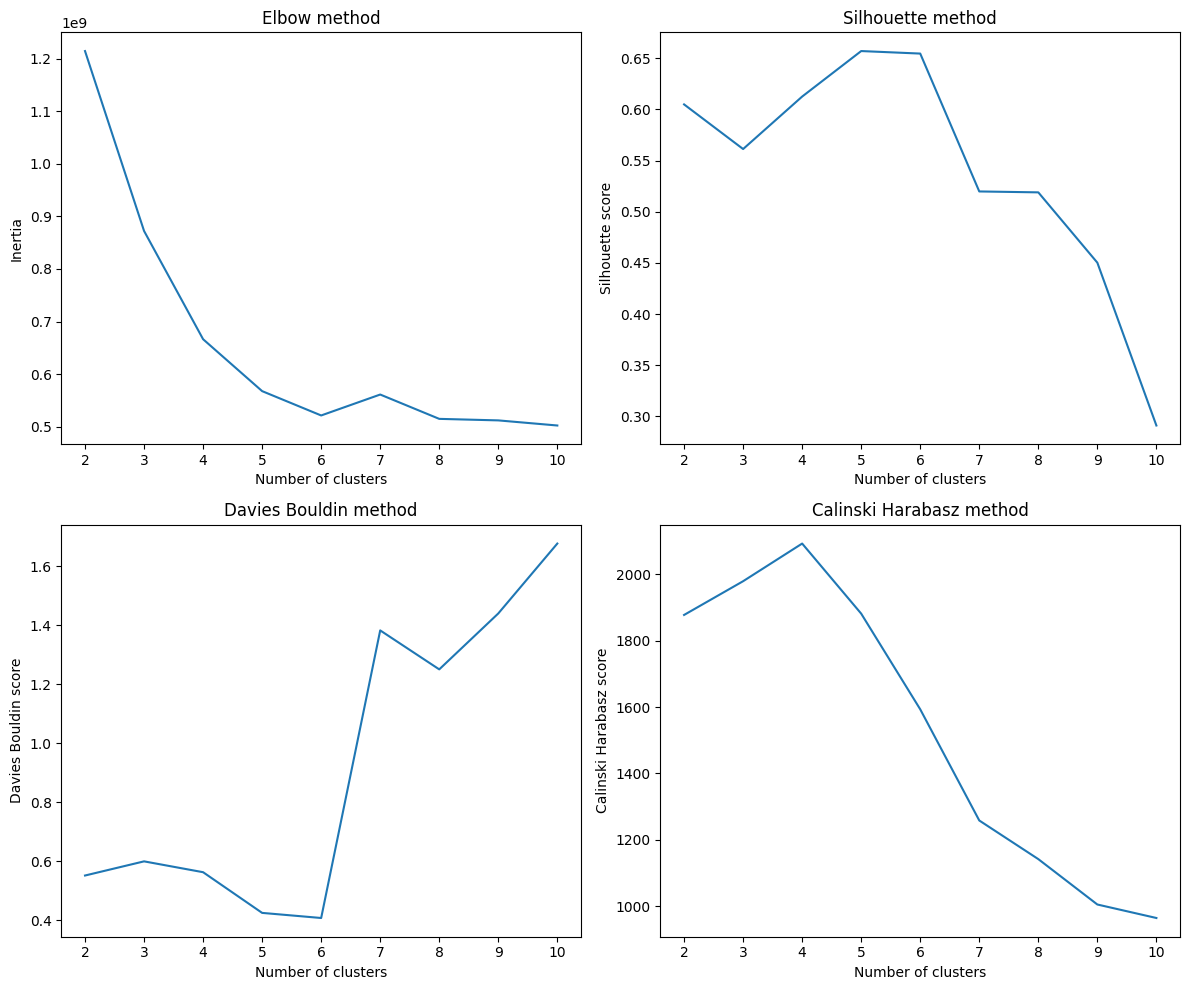

In [572]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Elbow method plot
axs[0, 0].plot(range(2, 11), inertia)
axs[0, 0].set_title("Elbow method")
axs[0, 0].set_xlabel("Number of clusters")
axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), silhouette_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

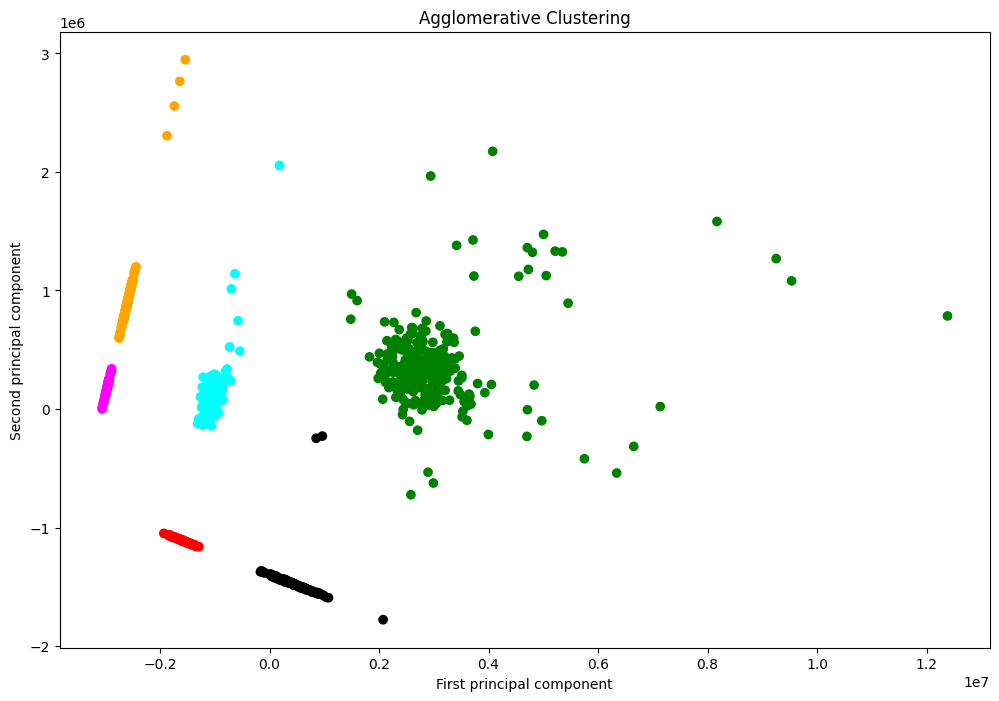

In [573]:
colors = ["red", "green", "cyan", "orange", "magenta", "black"]

# Create a scatter plot with custom colors for each cluster
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=[colors[label] for label in labels_[4]],
    cmap="plasma",
)
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

### PCA after scaling with 3 features


In [574]:
inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []

for i in range(2, 11):
    kmedoids = KMedoids(n_clusters=i, random_state=0).fit(X_reduced_three)
    labels = kmedoids.labels_
    inertia.append(kmedoids.inertia_)
    silhouette_scores.append(silhouette_score(X_reduced_three, labels))
    db_scores.append(davies_bouldin_score(X_reduced_three, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced_three, labels))

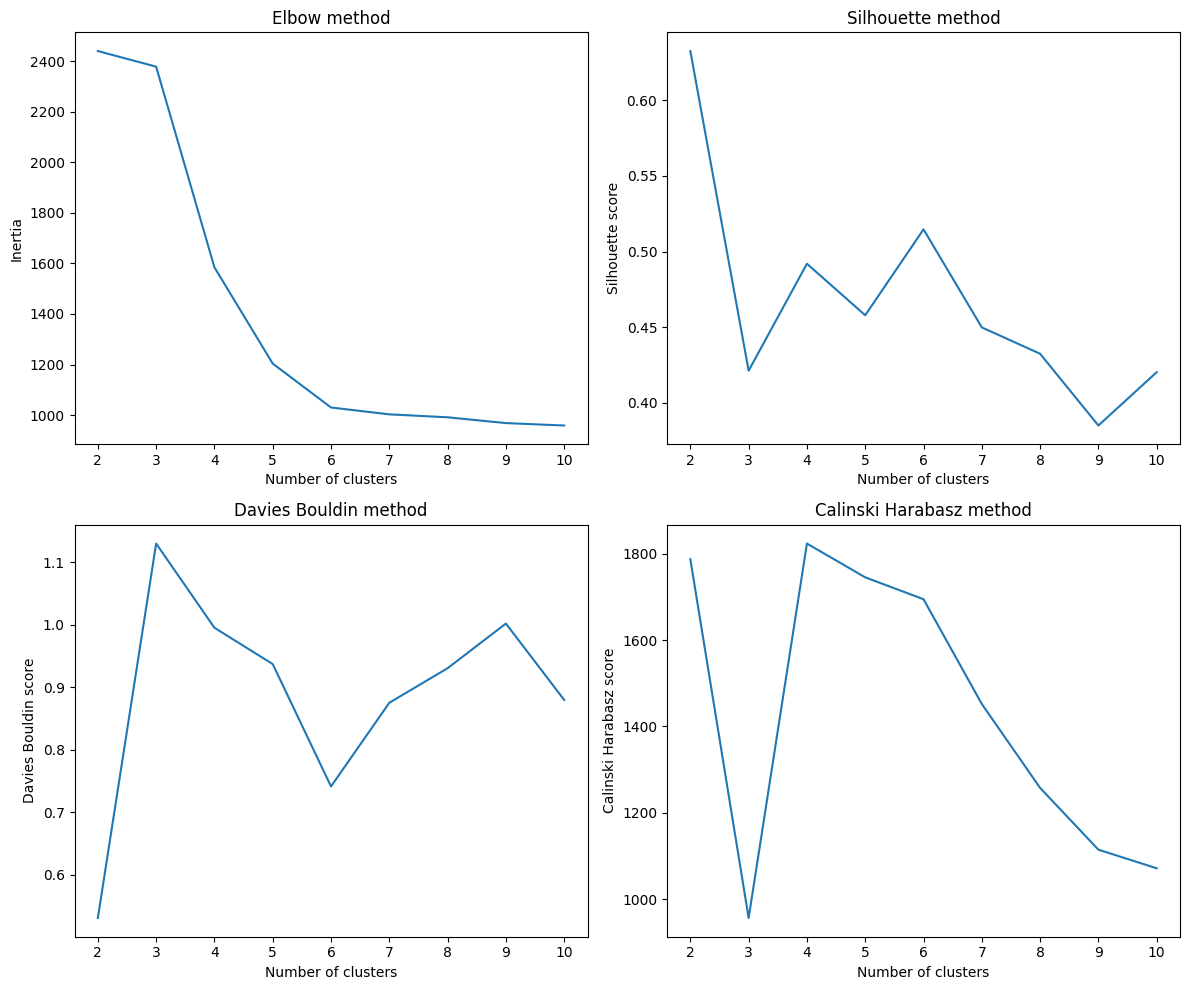

In [575]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Elbow method plot
axs[0, 0].plot(range(2, 11), inertia)
axs[0, 0].set_title("Elbow method")
axs[0, 0].set_xlabel("Number of clusters")
axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), silhouette_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

### PCA after robust scaling with 2 features


In [576]:
inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []

for i in range(2, 11):
    kmedoids = KMedoids(n_clusters=i, random_state=0).fit(X_reduced_robust_two)
    labels = kmedoids.labels_
    inertia.append(kmedoids.inertia_)
    silhouette_scores.append(silhouette_score(X_reduced_robust_two, labels))
    db_scores.append(davies_bouldin_score(X_reduced_robust_two, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced_robust_two, labels))

In [577]:
max(silhouette_scores)

0.683059284963731

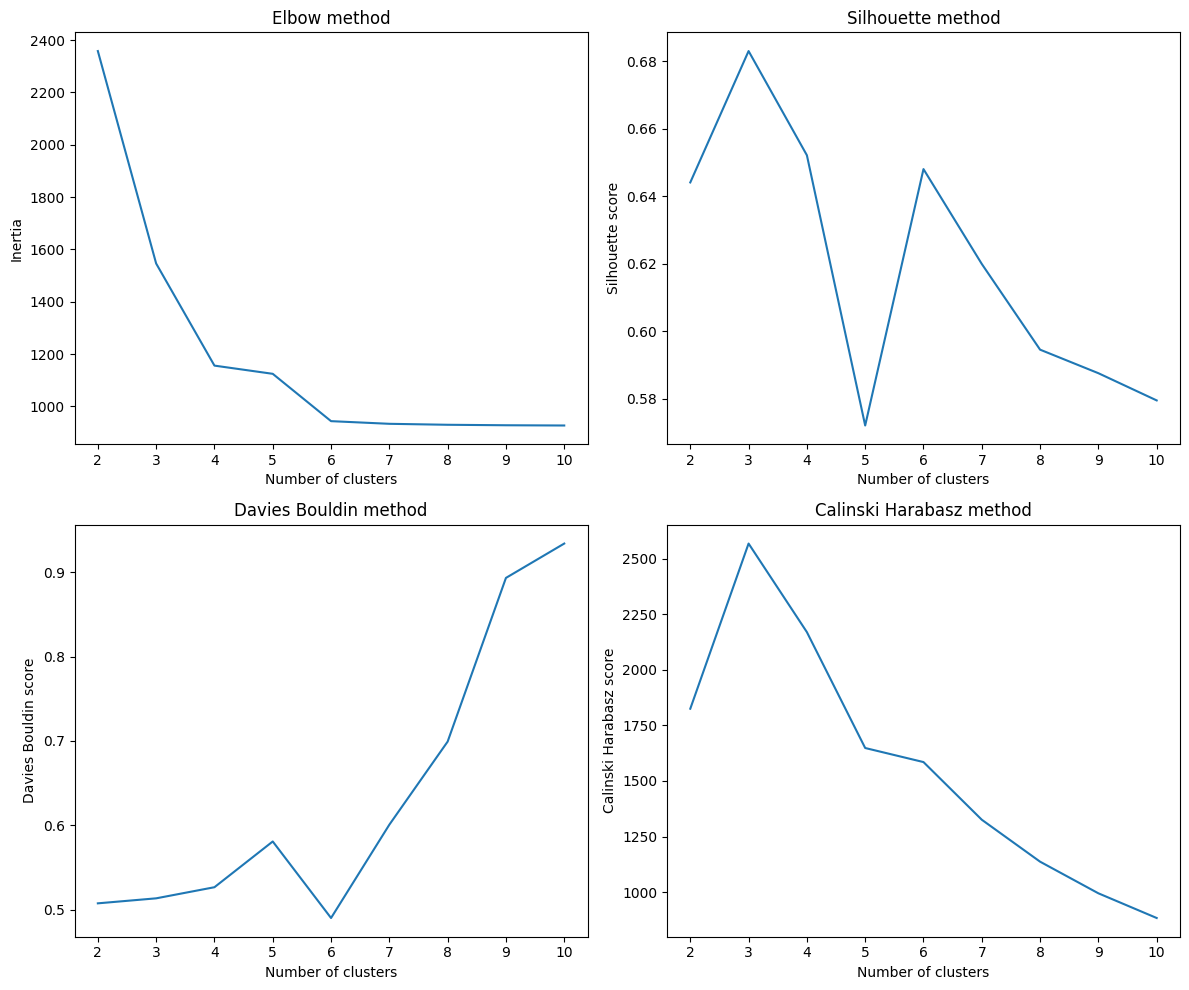

In [578]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Elbow method plot
axs[0, 0].plot(range(2, 11), inertia)
axs[0, 0].set_title("Elbow method")
axs[0, 0].set_xlabel("Number of clusters")
axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), silhouette_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

## DBSCAN


In [579]:
db_scan_df = outlet_info_df.copy(deep=True)
db_scan_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Butter Pecan Small Stick_earning,Chocolate Petite Bar_earning,Mint Bite-size Pop_earning,Strawberry Tiny Cup_earning,Vanilla Mini Cone_earning,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,644300.0,656550.0,552000.0,1003970.0,636100.0,0.0,0.0,0.0,0.0,0.0
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,674800.0,595980.0,795400.0,754160.0,786000.0,0.0,0.0,0.0,0.0,0.0
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,681700.0,730440.0,719200.0,862070.0,762500.0,0.0,0.0,0.0,0.0,0.0
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,952400.0,563310.0,875900.0,1015520.0,653000.0,0.0,0.0,0.0,0.0,0.0
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,886600.0,860580.0,624100.0,841720.0,705700.0,0.0,0.0,0.0,0.0,0.0


In [580]:
db_scan_df["average_week_units"] = (
    db_scan_df["weekly_sale_for_1"]
    + db_scan_df["weekly_sale_for_2"]
    + db_scan_df["weekly_sale_for_3"]
    + db_scan_df["weekly_sale_for_4"]
    + db_scan_df["weekly_sale_for_5"]
    + db_scan_df["weekly_sale_for_6"]
    + db_scan_df["weekly_sale_for_7"]
    + db_scan_df["weekly_sale_for_8"]
    + db_scan_df["weekly_sale_for_9"]
    + db_scan_df["weekly_sale_for_10"]
    + db_scan_df["weekly_sale_for_11"]
    + db_scan_df["weekly_sale_for_12"]
) / 12

db_scan_df["average_week_earning"] = (
    db_scan_df["weekly_earning_for_1"]
    + db_scan_df["weekly_earning_for_2"]
    + db_scan_df["weekly_earning_for_3"]
    + db_scan_df["weekly_earning_for_4"]
    + db_scan_df["weekly_earning_for_5"]
    + db_scan_df["weekly_earning_for_6"]
    + db_scan_df["weekly_earning_for_7"]
    + db_scan_df["weekly_earning_for_8"]
    + db_scan_df["weekly_earning_for_9"]
    + db_scan_df["weekly_earning_for_10"]
    + db_scan_df["weekly_earning_for_11"]
    + db_scan_df["weekly_earning_for_12"]
) / 12

db_scan_df["average_week_volume"] = (
    db_scan_df["weekly_sold_volume_for_1"]
    + db_scan_df["weekly_sold_volume_for_2"]
    + db_scan_df["weekly_sold_volume_for_3"]
    + db_scan_df["weekly_sold_volume_for_4"]
    + db_scan_df["weekly_sold_volume_for_5"]
    + db_scan_df["weekly_sold_volume_for_6"]
    + db_scan_df["weekly_sold_volume_for_7"]
    + db_scan_df["weekly_sold_volume_for_8"]
    + db_scan_df["weekly_sold_volume_for_9"]
    + db_scan_df["weekly_sold_volume_for_10"]
    + db_scan_df["weekly_sold_volume_for_11"]
    + db_scan_df["weekly_sold_volume_for_12"]
) / 12

In [581]:
# drop the duplicates
outlets_area_df = outlets_area_df.drop_duplicates(subset=["Outlet_ID"])
outlets_area_df.shape

(951, 2)

In [582]:
outlets_area_df.head()

,Outlet_ID,area(sqft)
0,ID7203,5660
1,ID1878,4138
2,ID1740,5546
3,ID4366,5134
4,ID8358,4100


In [583]:
db_scan_df = db_scan_df.merge(outlets_area_df, on="Outlet_ID", how="left")
db_scan_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Vanilla Mini Cone_earning,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,average_week_units,average_week_earning,average_week_volume,area(sqft)
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,636100.0,0.0,0.0,0.0,0.0,0.0,2895.500000,291076.666667,579.100000,5660
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,786000.0,0.0,0.0,0.0,0.0,0.0,3003.333333,300528.333333,600.666667,4138
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,762500.0,0.0,0.0,0.0,0.0,0.0,3132.250000,312992.500000,626.450000,5546
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,653000.0,0.0,0.0,0.0,0.0,0.0,3358.666667,338344.166667,671.733333,5134
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,705700.0,0.0,0.0,0.0,0.0,0.0,3281.500000,326558.333333,656.300000,4100


In [584]:
a = db_scan_df.columns.tolist()
"area(sqft)" in a

True

In [585]:
db_scan_df_new = db_scan_df[
    ["average_week_units", "average_week_earning", "average_week_volume"]
]

In [586]:
# scale using robust scaler
scaler = RobustScaler()
db_scan_df_new = scaler.fit_transform(db_scan_df_new)

In [587]:
# run DBSCAN clustering algorithm
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=5)

dbscan.fit(db_scan_df_new)

dbscan_labels = dbscan.labels_

# check silhouette score

print("Silhouette score: ", silhouette_score(db_scan_df_new, dbscan_labels))

Silhouette score:  0.6974552201698442


In [588]:
set(dbscan_labels)

{-1, 0}

In [589]:
from sklearn.cluster import DBSCAN

param_grid = {
    "eps": [0.1, 0.2, 0.3, 0.4, 0.5],
    "min_samples": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"],
    "algorithm": ["auto", "kd_tree", "brute"],
    "p": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

eps = 0.5
min_samples = 5
metric = "euclidean"
algorithm = "auto"
p = None

silhouette_score_vals = []

for eps_val in param_grid["eps"]:
    for min_sample_val in param_grid["min_samples"]:
        for metric_val in param_grid["metric"]:
            for algo_val in param_grid["algorithm"]:
                for p_val in param_grid["p"]:
                    if algo_val != "minowski":
                        p_val = None
                    try:
                        dbscan = DBSCAN(
                            eps=eps_val,
                            min_samples=min_sample_val,
                            metric=metric_val,
                            algorithm=algo_val,
                            p=p_val,
                        )
                        dbscan.fit(db_scan_df)
                        labels = dbscan.labels_
                        if len(set(labels)) > 1:
                            s_score = silhouette_score(db_scan_df, labels)
                            silhouette_score_vals.append(s_score)
                    except:
                        print("Error")
                        print(eps_val, min_sample_val, metric_val, algo_val, p_val)

Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean auto None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean kd_tree None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None
Error
0.1 2 euclidean brute None


## Agglomerative Clustering


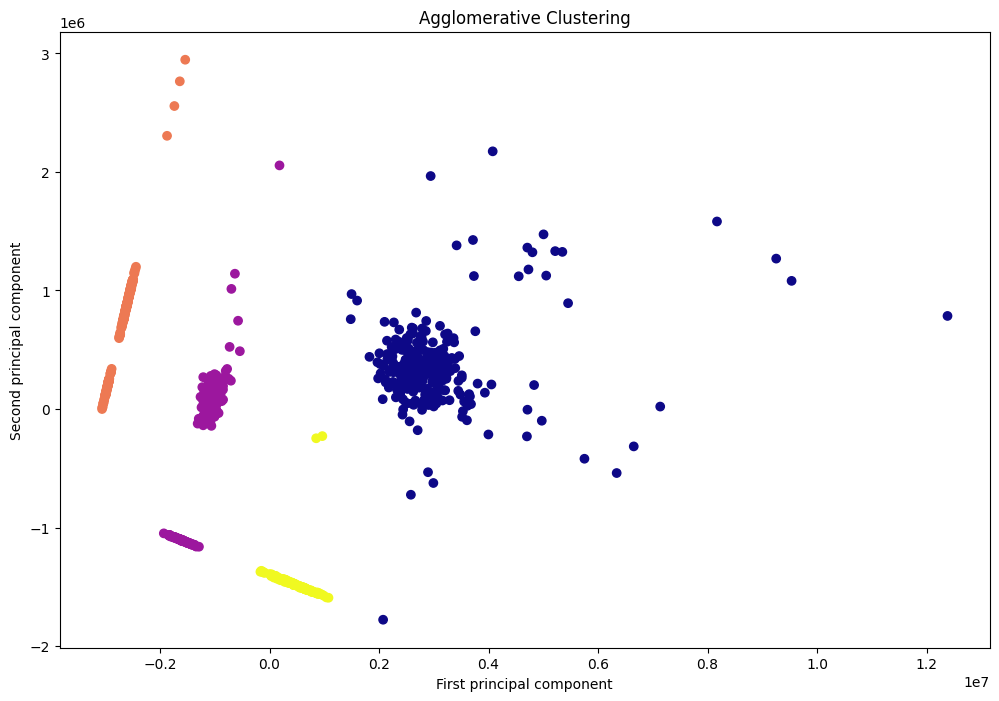

In [590]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_reduced)
labels = agg.labels_

# plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap="plasma")
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

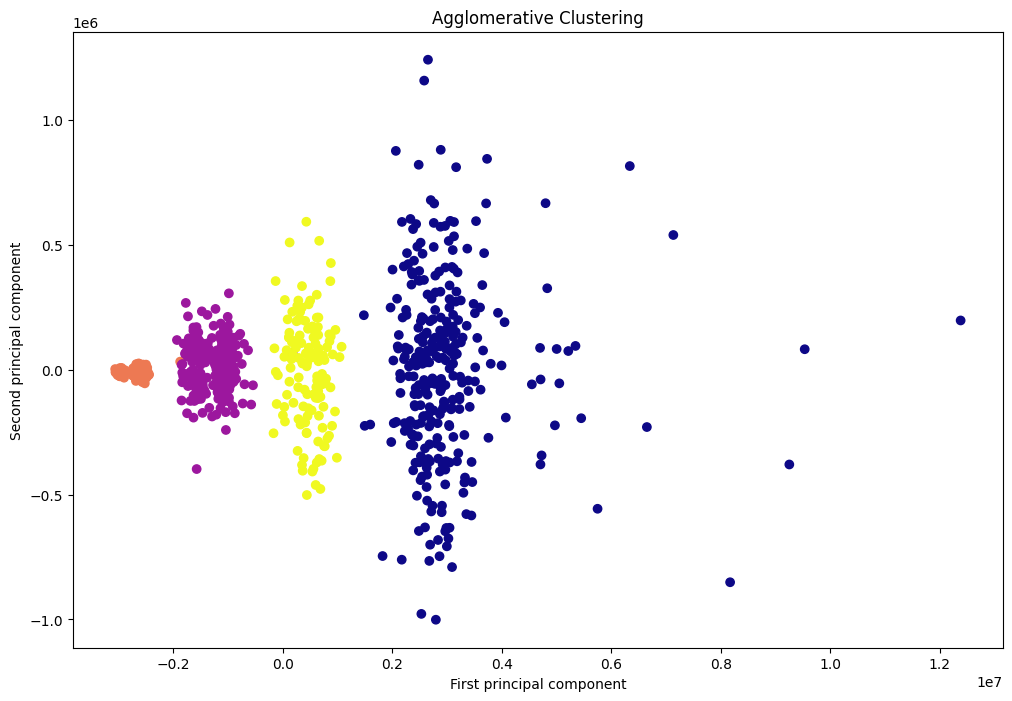

In [591]:
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 3], c=labels, cmap="plasma")
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

In [592]:
print("Silhouette score: ", silhouette_score(X_reduced, labels))

Silhouette score:  0.6121122522433842


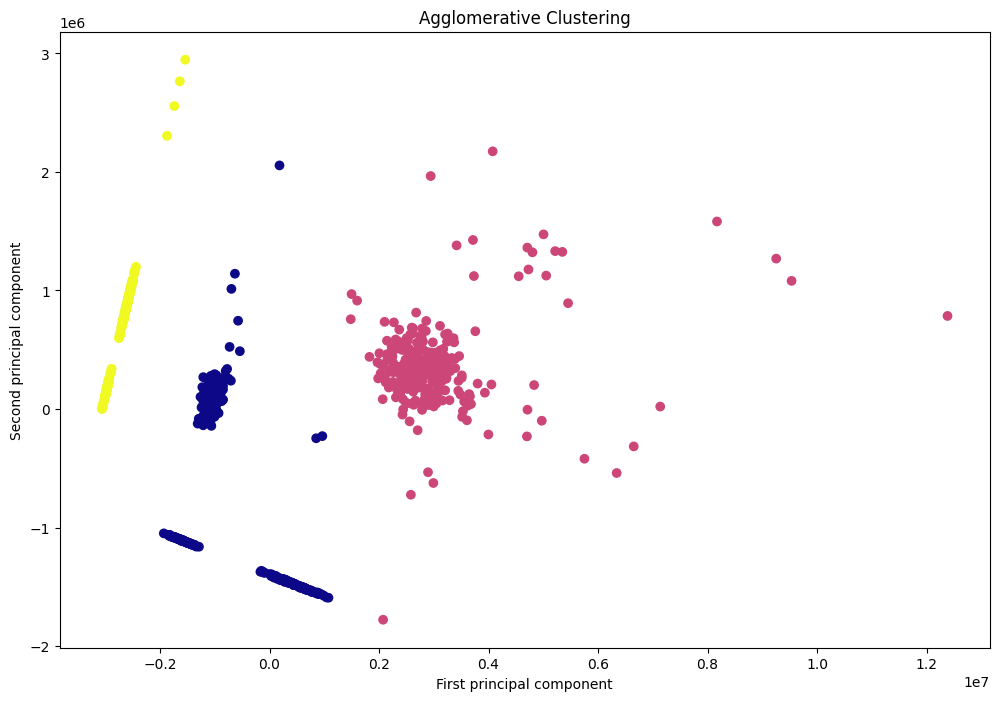

In [593]:
# run agglomerative clustering
# import agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X_reduced)
labels = agg.labels_

# plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap="plasma")
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

In [594]:
print("Silhouette score: ", silhouette_score(X_reduced, labels))

Silhouette score:  0.5621206115949503


In [595]:
sil_scores = []
db_scores = []
ch_scores = []
inertia = []
labels_ = []

for i in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=i, linkage="ward").fit(X_reduced)
    labels = agg.labels_
    labels_.append(labels)
    # inertia.append(agg.inertia_)
    s_score = silhouette_score(X_reduced, labels)
    db_scores.append(davies_bouldin_score(X_reduced, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced, labels))
    # print("Silhouette score: ", s_score)
    sil_scores.append(s_score)

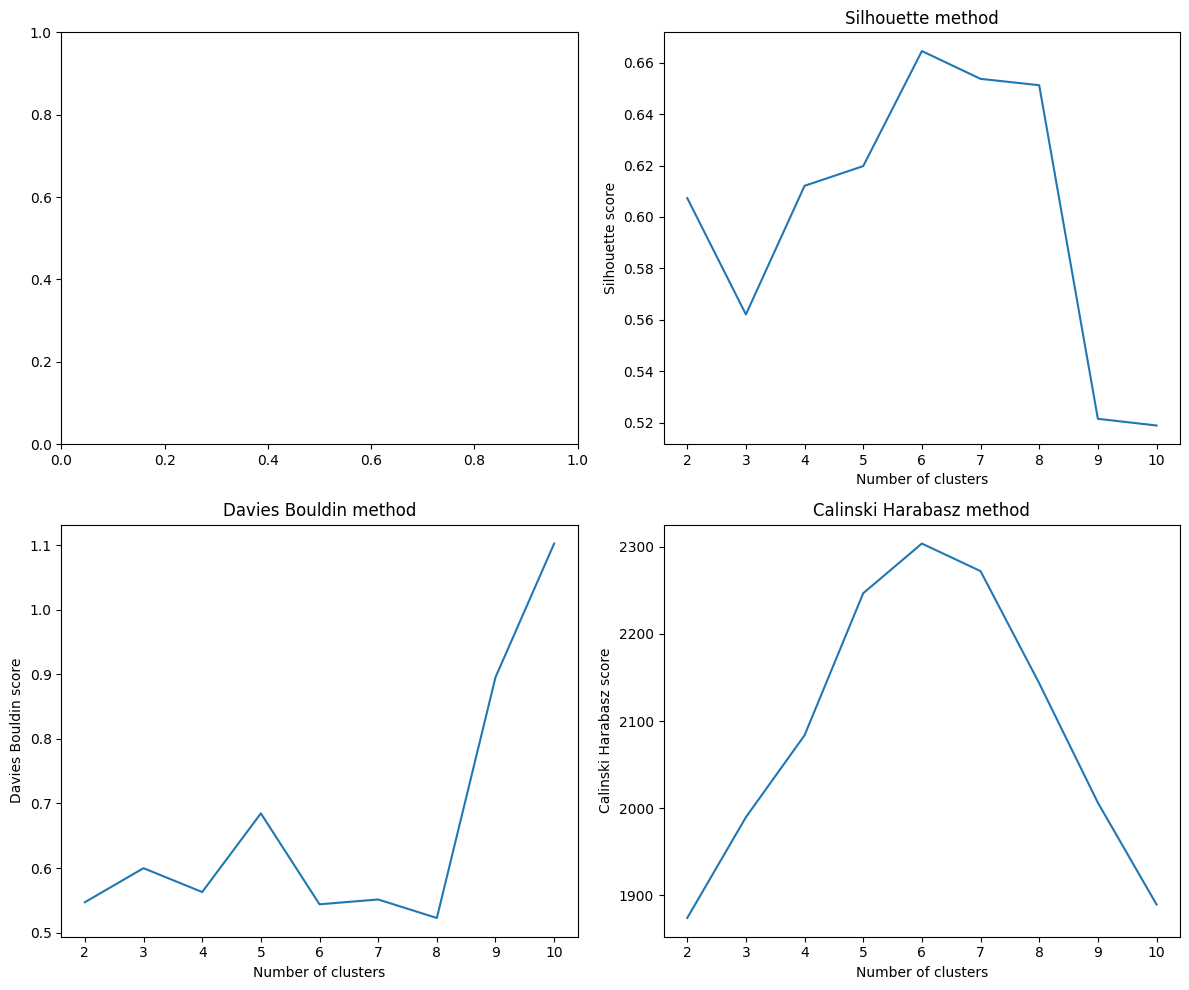

In [596]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

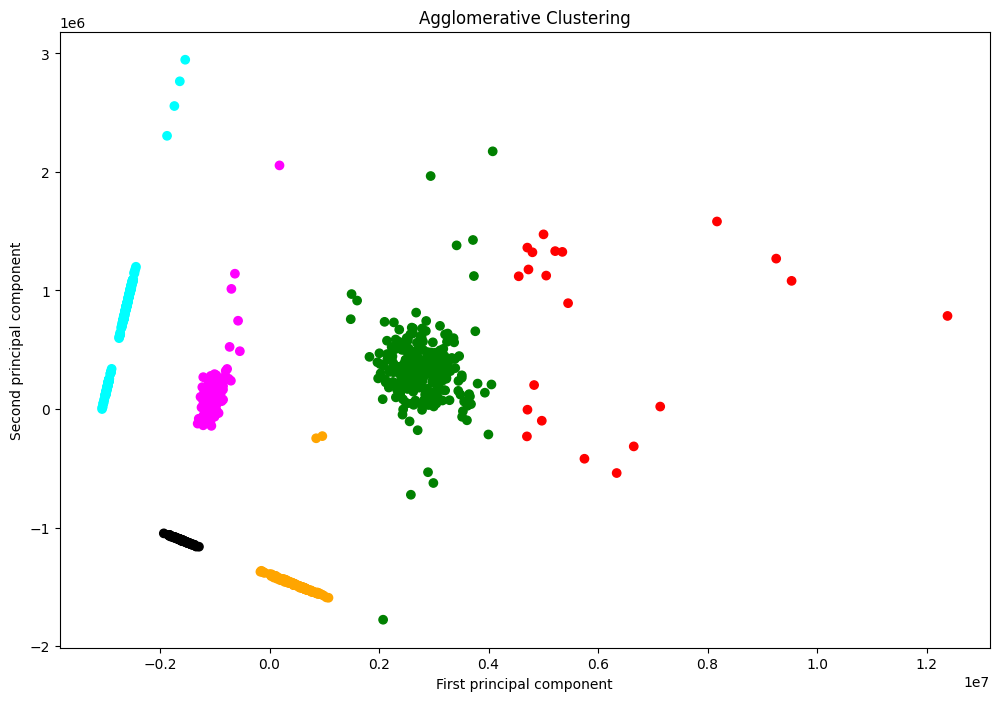

In [597]:
colors = ["red", "green", "cyan", "orange", "magenta", "black"]

# Create a scatter plot with custom colors for each cluster
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced_two[:, 0],
    X_reduced_two[:, 1],
    c=[colors[label] for label in labels_[4]],
    cmap="plasma",
)
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

With two features


In [598]:
sil_scores = []
db_scores = []
ch_scores = []
inertia = []
labels_ = []

for i in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=i, linkage="ward").fit(X_reduced_two)
    labels = agg.labels_
    labels_.append(labels)
    # inertia.append(agg.inertia_)
    s_score = silhouette_score(X_reduced_two, labels)
    db_scores.append(davies_bouldin_score(X_reduced_two, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced_two, labels))
    # print("Silhouette score: ", s_score)
    sil_scores.append(s_score)

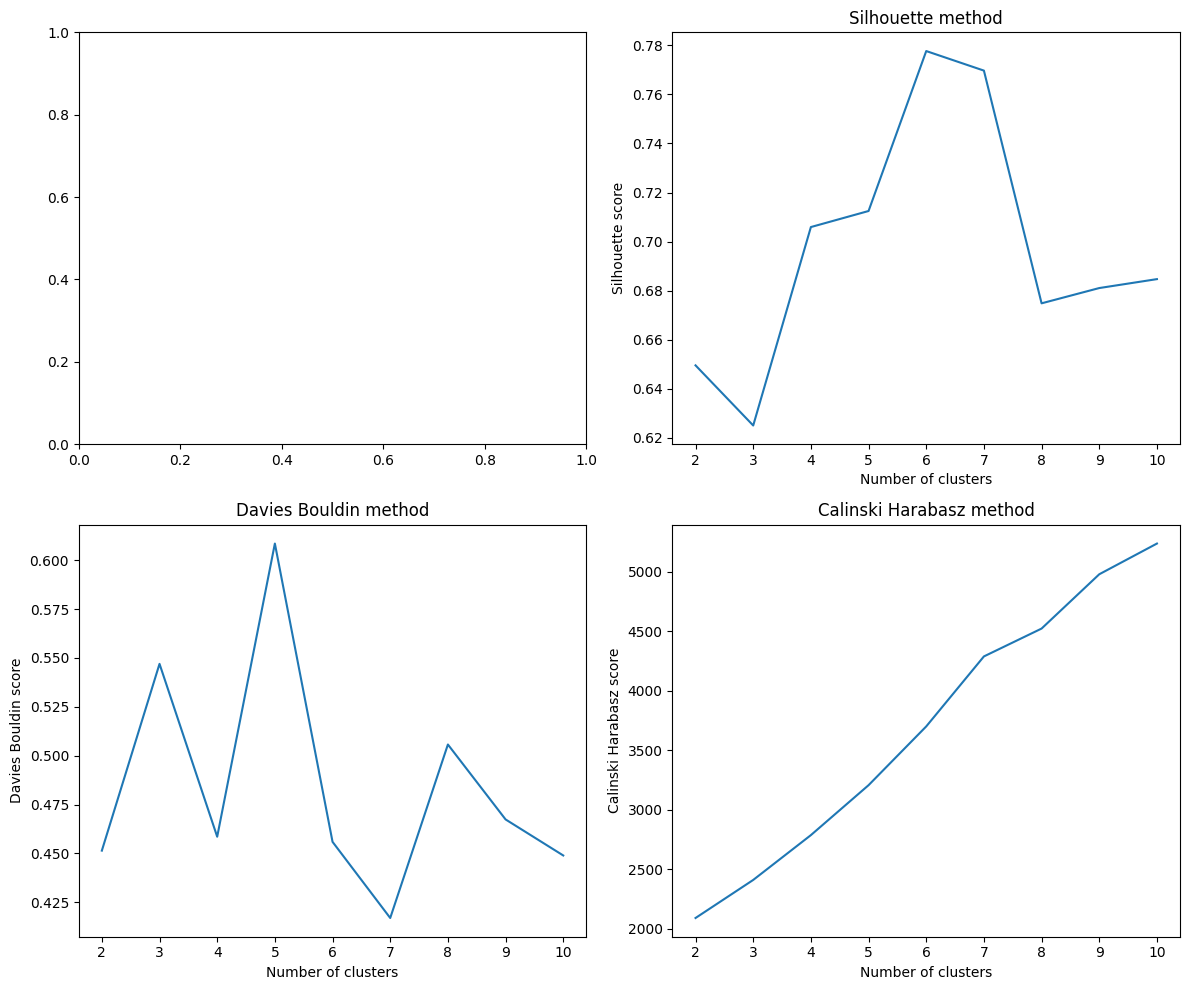

In [599]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

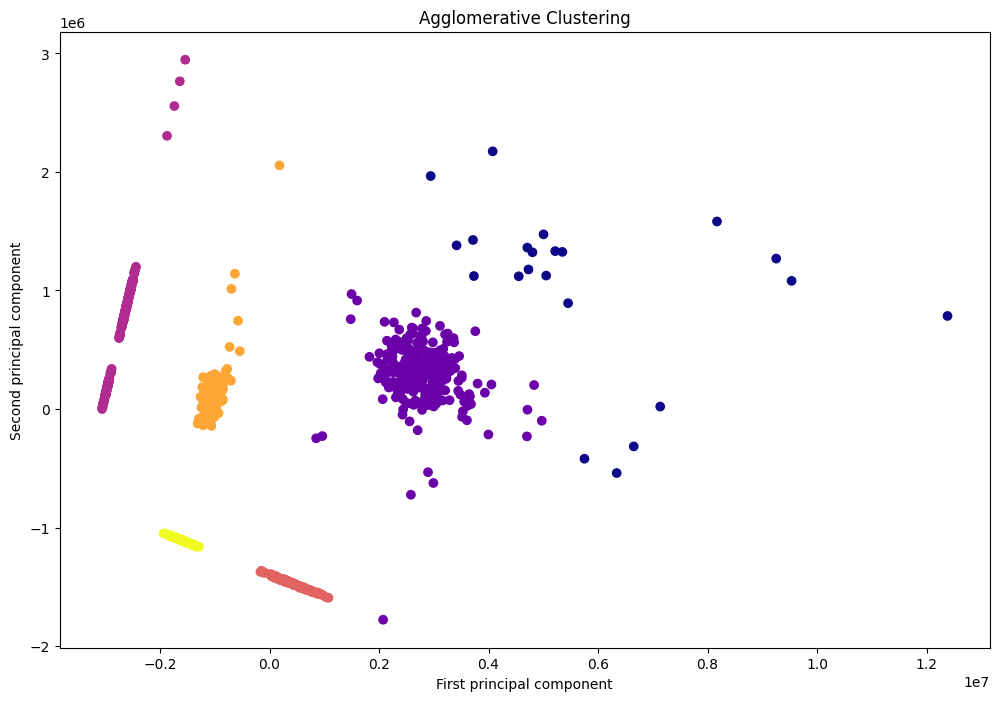

In [600]:
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced_two[:, 0], X_reduced_two[:, 1], c=labels_[4], cmap="plasma")
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

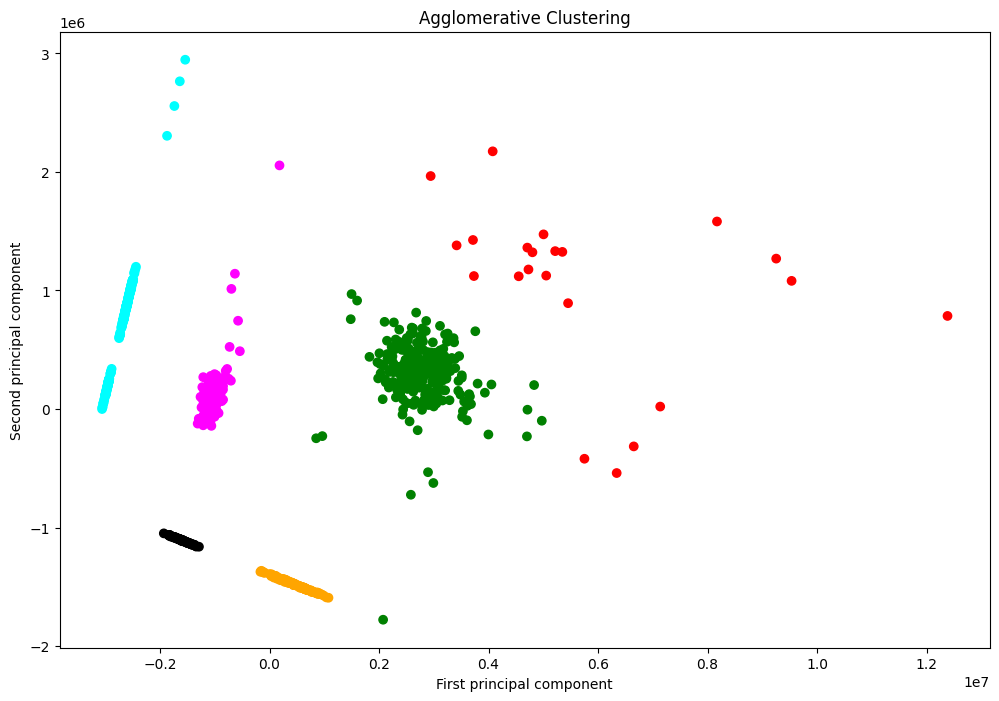

In [601]:
colors = ["red", "green", "cyan", "orange", "magenta", "black"]

# Create a scatter plot with custom colors for each cluster
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced_two[:, 0],
    X_reduced_two[:, 1],
    c=[colors[label] for label in labels_[4]],
    cmap="plasma",
)
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

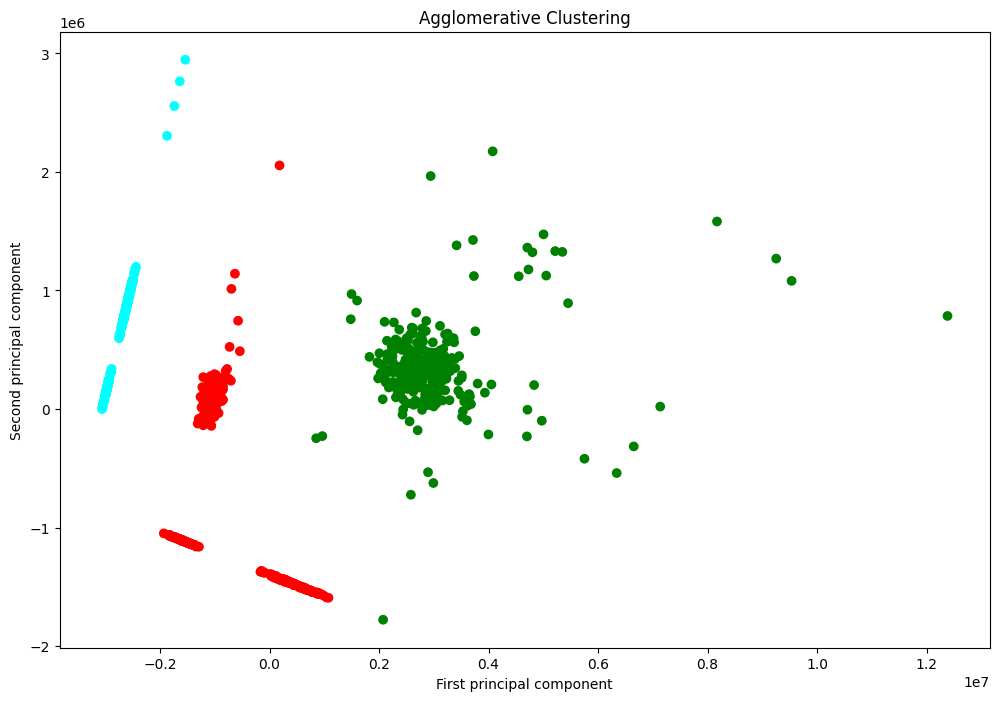

In [602]:
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced_two[:, 0],
    X_reduced_two[:, 1],
    c=[colors[label] for label in labels_[1]],
    cmap="plasma",
)
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

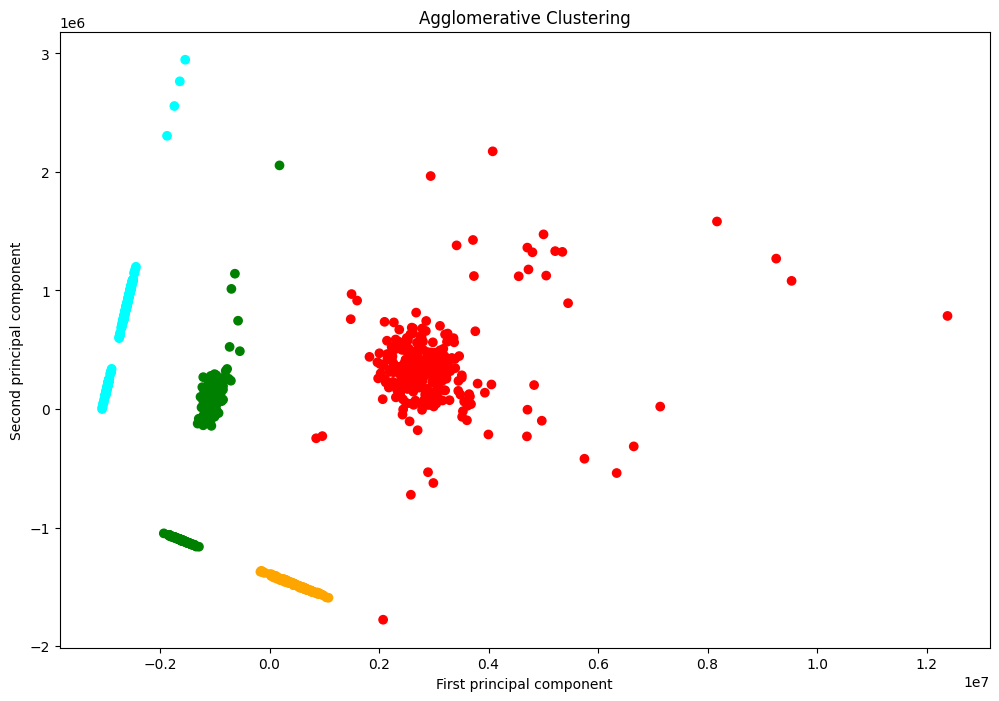

In [603]:
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced_two[:, 0],
    X_reduced_two[:, 1],
    c=[colors[label] for label in labels_[2]],
    cmap="plasma",
)
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

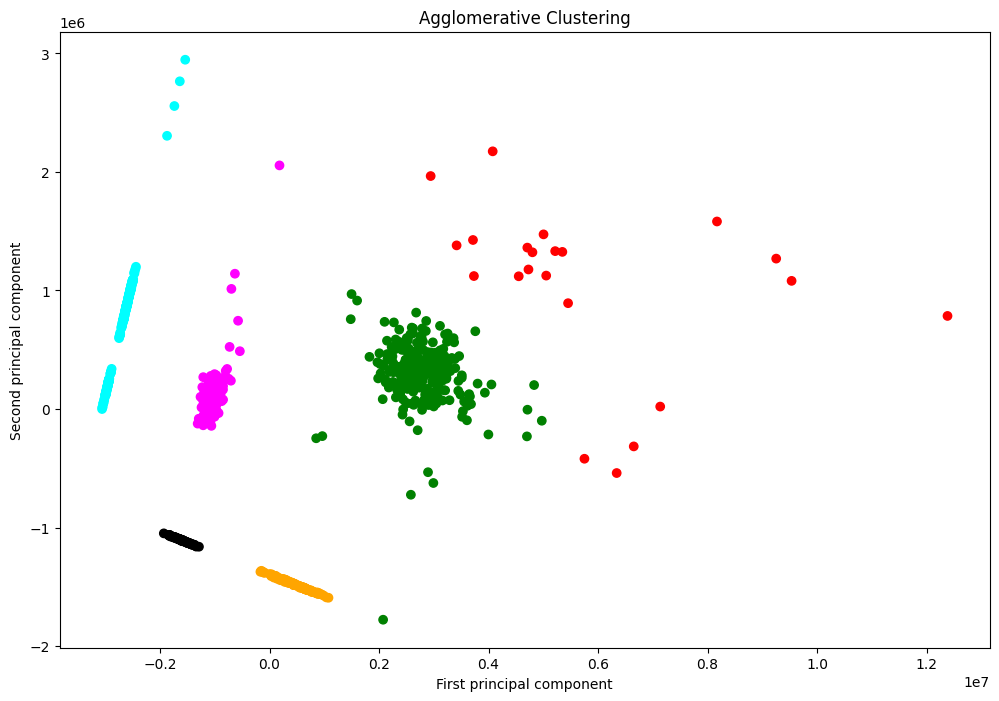

In [604]:
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced_two[:, 0],
    X_reduced_two[:, 1],
    c=[colors[label] for label in labels_[4]],
    cmap="plasma",
)
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

In [605]:
pca_process_df.shape

(951, 66)

In [606]:
param_grid = {
    "linkage": ["ward", "complete", "average", "single"],
    "compute_distances": [True, False],
    "metric": ["euclidean", "manhattan", "cosine"],
}

sil_scores = []
db_scores = []
ch_scores = []
inertia = []
labels_ = []

for i in range(2, 11):
    cur_s_score = -1
    cur_db_score = -1
    cur_ch_score = -1
    cur_labels = []
    for linkage_val in param_grid["linkage"]:
        for metric_val in param_grid["metric"]:
            for compute_distances_val in param_grid["compute_distances"]:
                if linkage_val == "ward":
                    if metric_val != "euclidean":
                        continue
                agg = AgglomerativeClustering(
                    n_clusters=i,
                    linkage=linkage_val,
                    metric=metric_val,
                    compute_distances=compute_distances_val,
                ).fit(X_reduced_two)
                labels = agg.labels_
                labels_.append(labels)
                # inertia.append(agg.inertia_)
                s_score = silhouette_score(X_reduced_two, labels)
                if s_score > cur_s_score:
                    cur_s_score = s_score
                    cur_db_score = davies_bouldin_score(X_reduced_two, labels)
                    cur_ch_score = calinski_harabasz_score(X_reduced_two, labels)
                    cur_labels = labels
    sil_scores.append(cur_s_score)
    db_scores.append(cur_db_score)
    ch_scores.append(cur_ch_score)
    labels_.append(cur_labels)

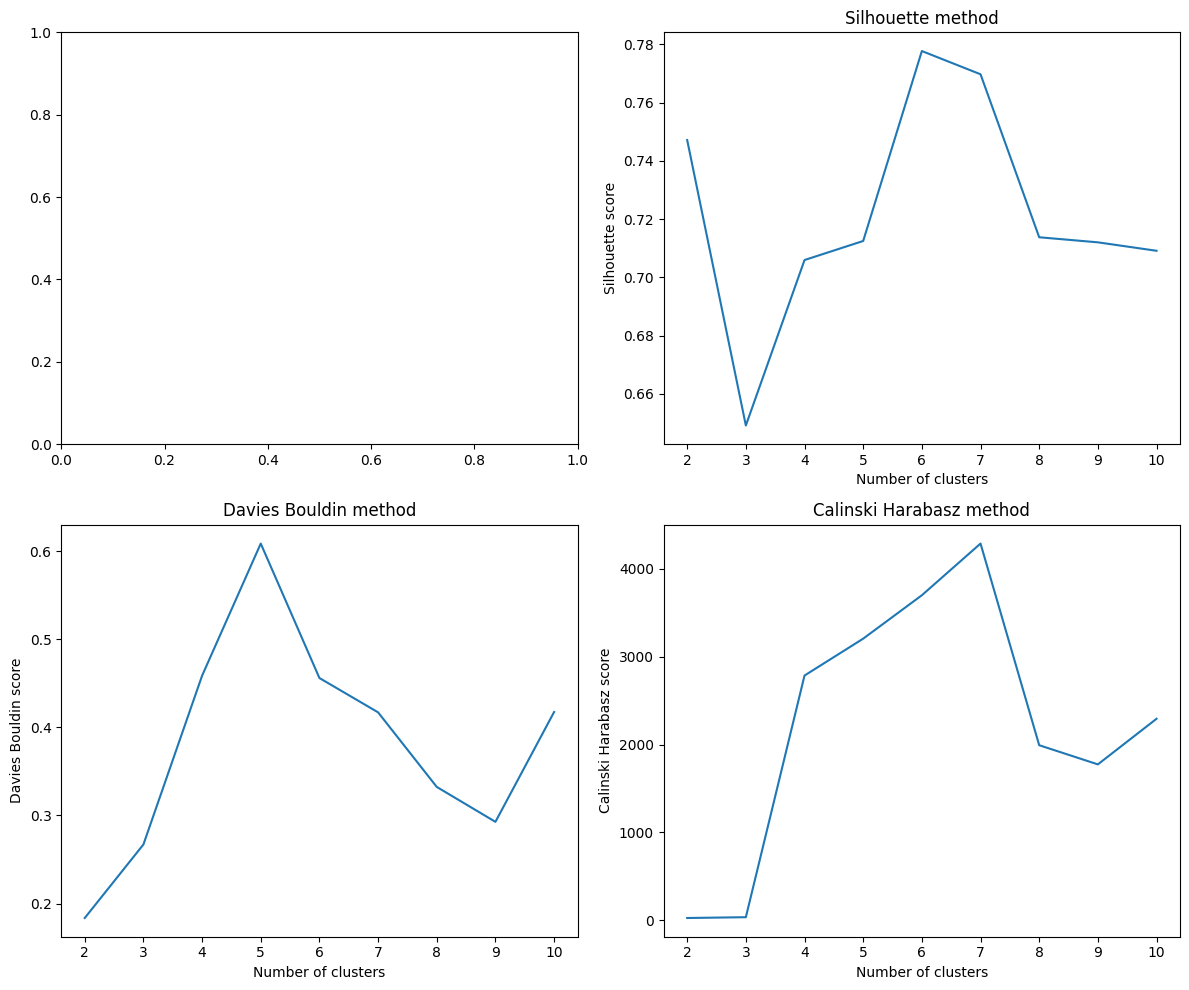

In [607]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

In [608]:
sil_scores = []
db_scores = []
ch_scores = []
inertia = []
labels_ = []

for i in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=i, linkage="ward").fit(X_reduced_three)
    labels = agg.labels_
    labels_.append(labels)
    # inertia.append(agg.inertia_)
    s_score = silhouette_score(X_reduced_three, labels)
    db_scores.append(davies_bouldin_score(X_reduced_three, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced_three, labels))
    # print("Silhouette score: ", s_score)
    sil_scores.append(s_score)

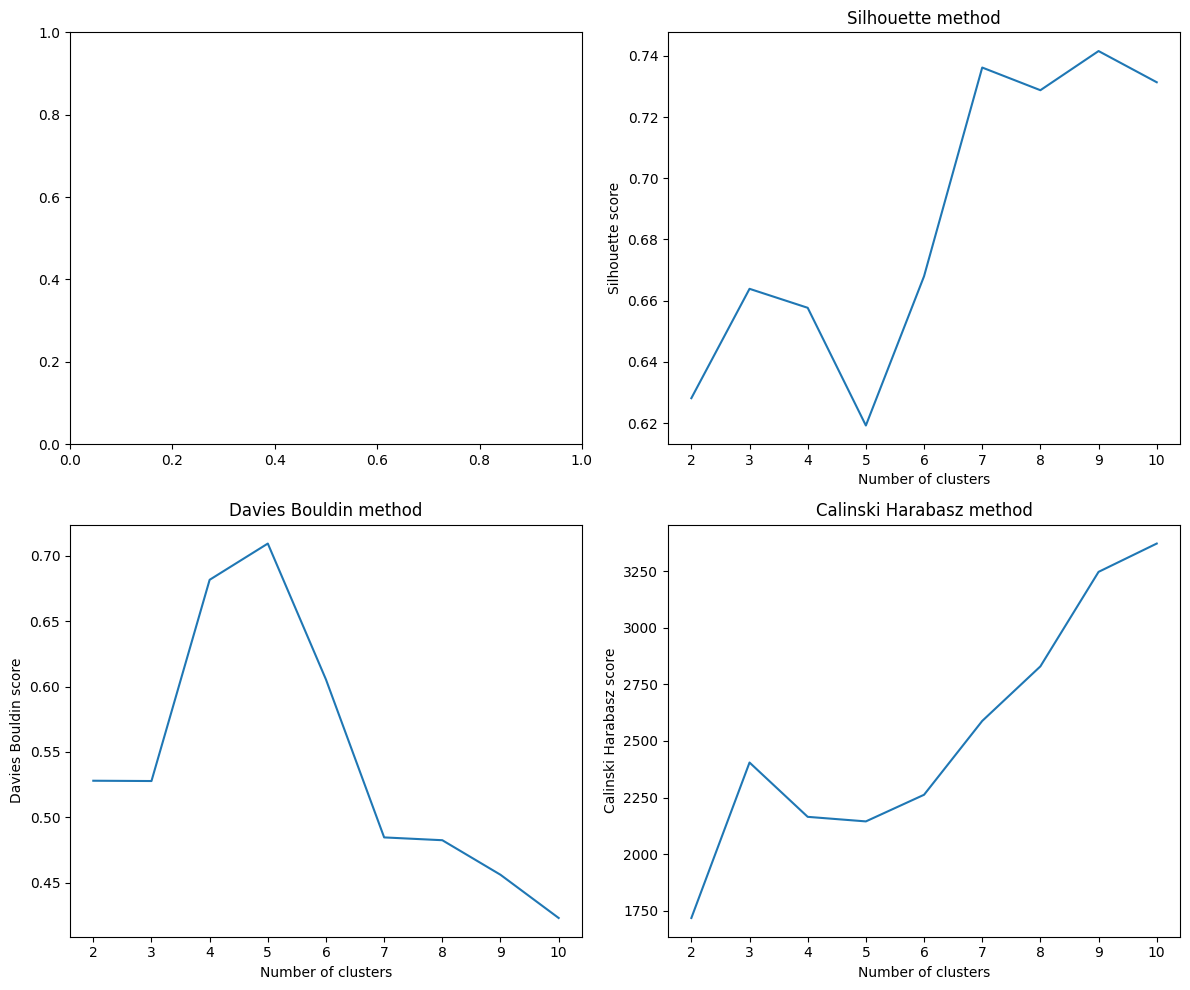

In [609]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

In [610]:
sil_scores = []
db_scores = []
ch_scores = []
inertia = []
labels_ = []

for i in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=i, linkage="ward").fit(
        X_reduced_robust_two
    )
    labels = agg.labels_
    labels_.append(labels)
    # inertia.append(agg.inertia_)
    s_score = silhouette_score(X_reduced_robust_two, labels)
    db_scores.append(davies_bouldin_score(X_reduced_robust_two, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced_robust_two, labels))
    # print("Silhouette score: ", s_score)
    sil_scores.append(s_score)

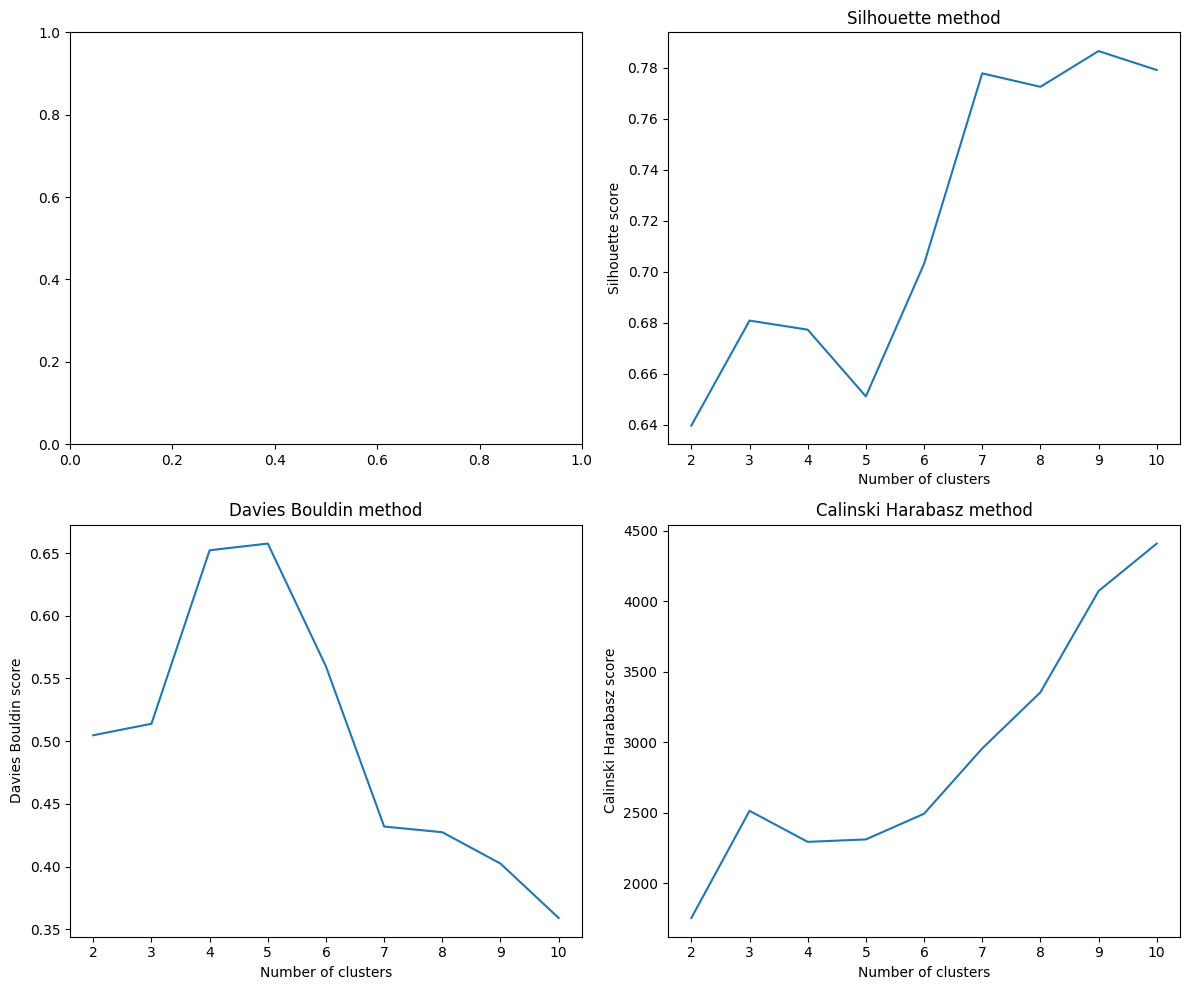

In [611]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

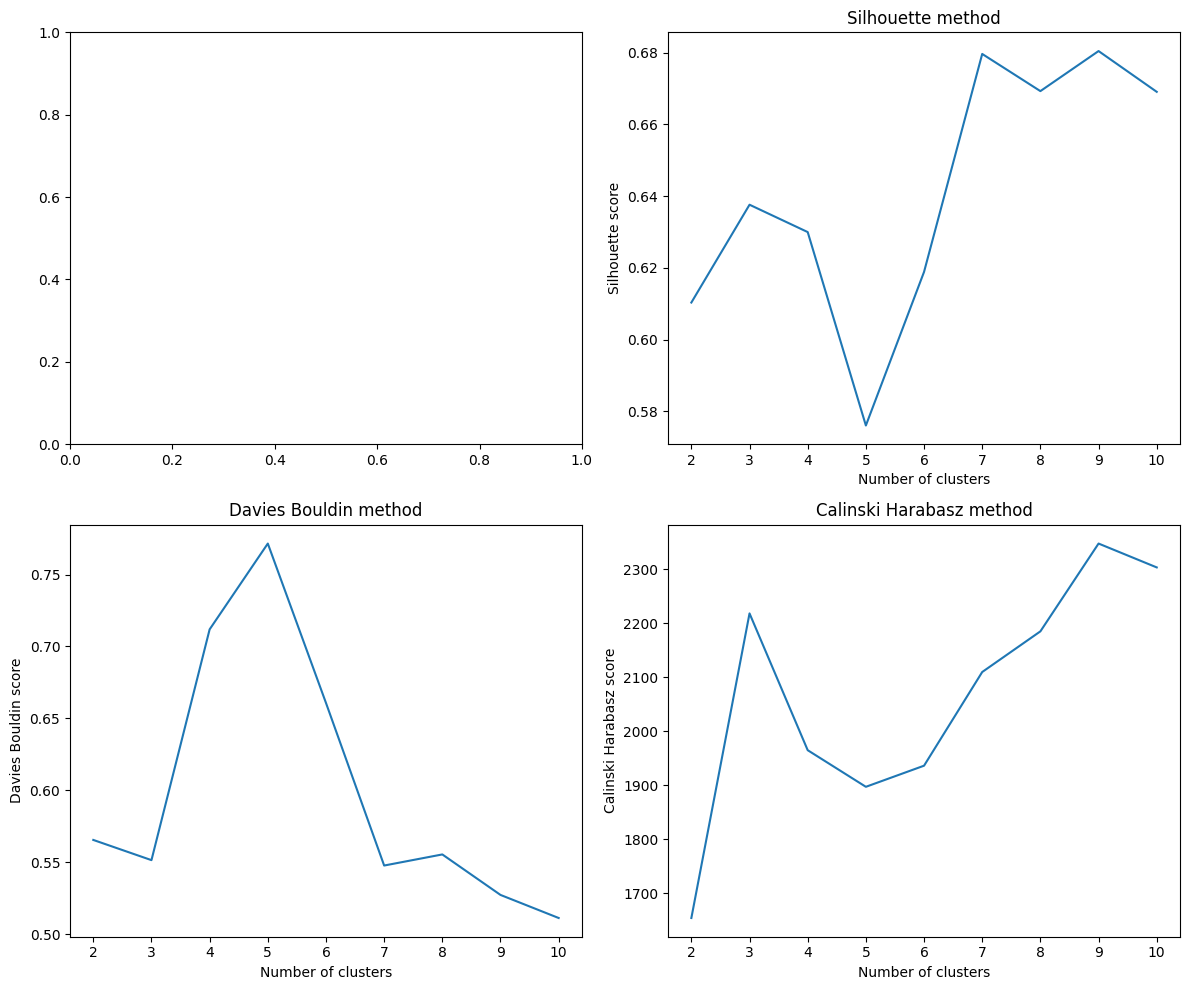

In [612]:
sil_scores = []
db_scores = []
ch_scores = []
inertia = []
labels_ = []

for i in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=i, linkage="ward").fit(X_reduced_five)
    labels = agg.labels_
    labels_.append(labels)
    # inertia.append(agg.inertia_)
    s_score = silhouette_score(X_reduced_five, labels)
    db_scores.append(davies_bouldin_score(X_reduced_five, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced_five, labels))
    # print("Silhouette score: ", s_score)
    sil_scores.append(s_score)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

## BIRCH Clustering


In [613]:
from sklearn.cluster import Birch

sil_scores = []
db_scores = []
ch_scores = []
# inertia = []
labels_ = []

for cluster in range(2, 11):
    brc = Birch(n_clusters=cluster).fit(X_reduced_two)
    labels = brc.labels_
    labels_.append(labels)
    # inertia.append(brc.inertia_)
    ch_score = calinski_harabasz_score(X_reduced_two, labels)
    sil_score = silhouette_score(X_reduced_two, labels)
    db_score = davies_bouldin_score(X_reduced_two, labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)

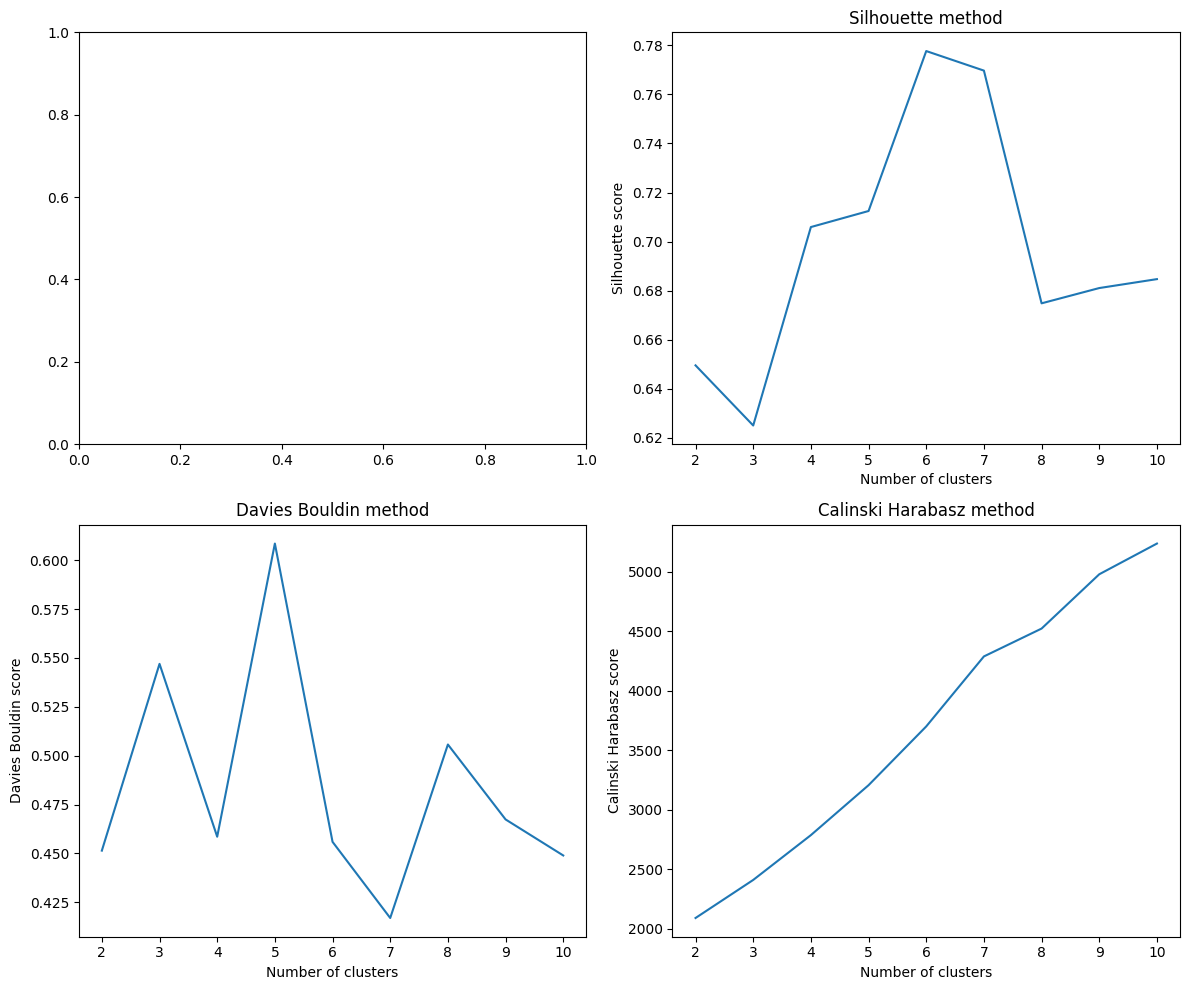

In [614]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

In [615]:
from sklearn.cluster import Birch

sil_scores = []
db_scores = []
ch_scores = []
# inertia = []
labels_ = []

for cluster in range(2, 11):
    brc = Birch(n_clusters=cluster).fit(X_reduced)
    labels = brc.labels_
    labels_.append(labels)
    # inertia.append(brc.inertia_)
    ch_score = calinski_harabasz_score(X_reduced, labels)
    sil_score = silhouette_score(X_reduced, labels)
    db_score = davies_bouldin_score(X_reduced, labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)

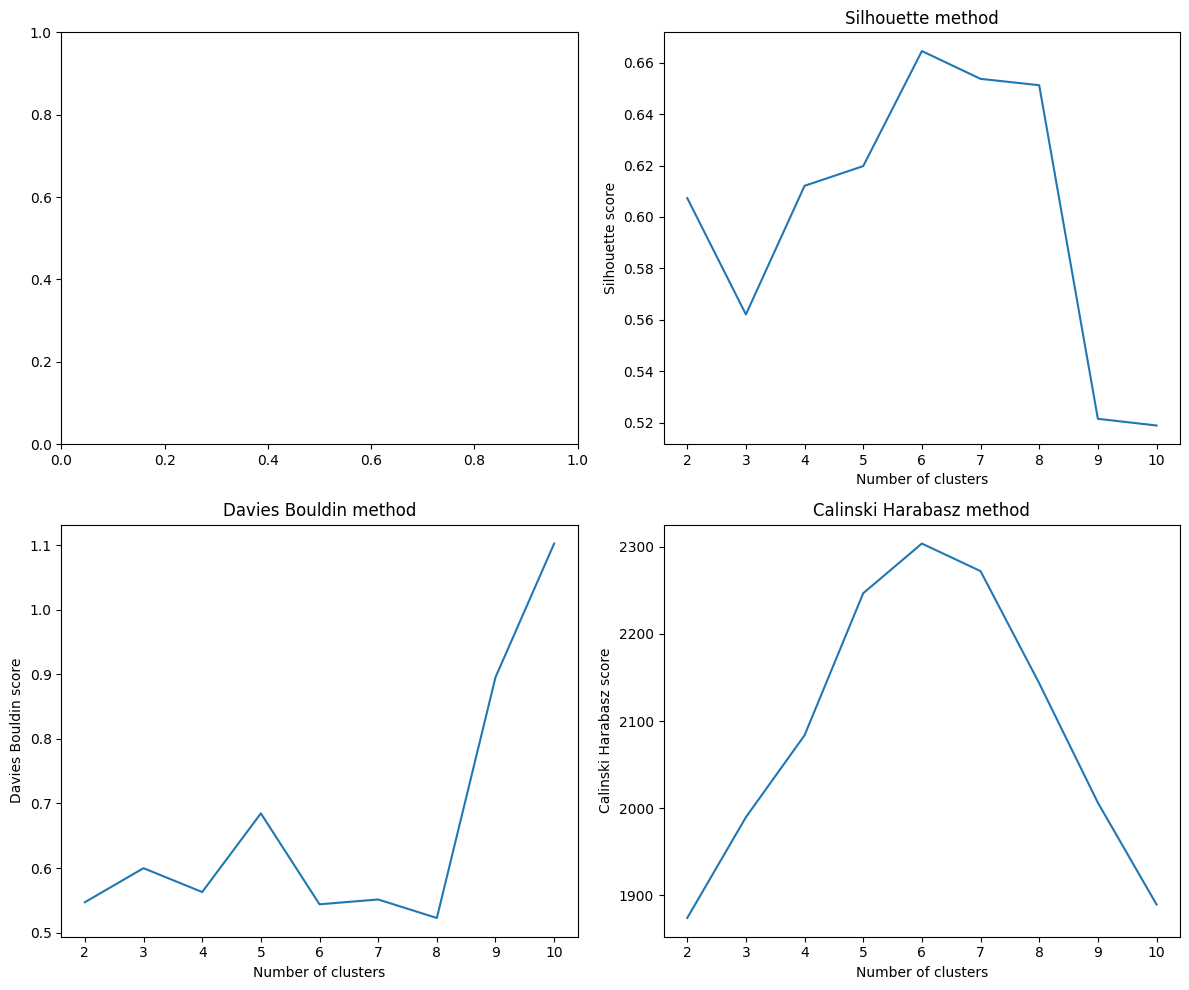

In [616]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

In [617]:
max(sil_scores)

0.6644935809195635

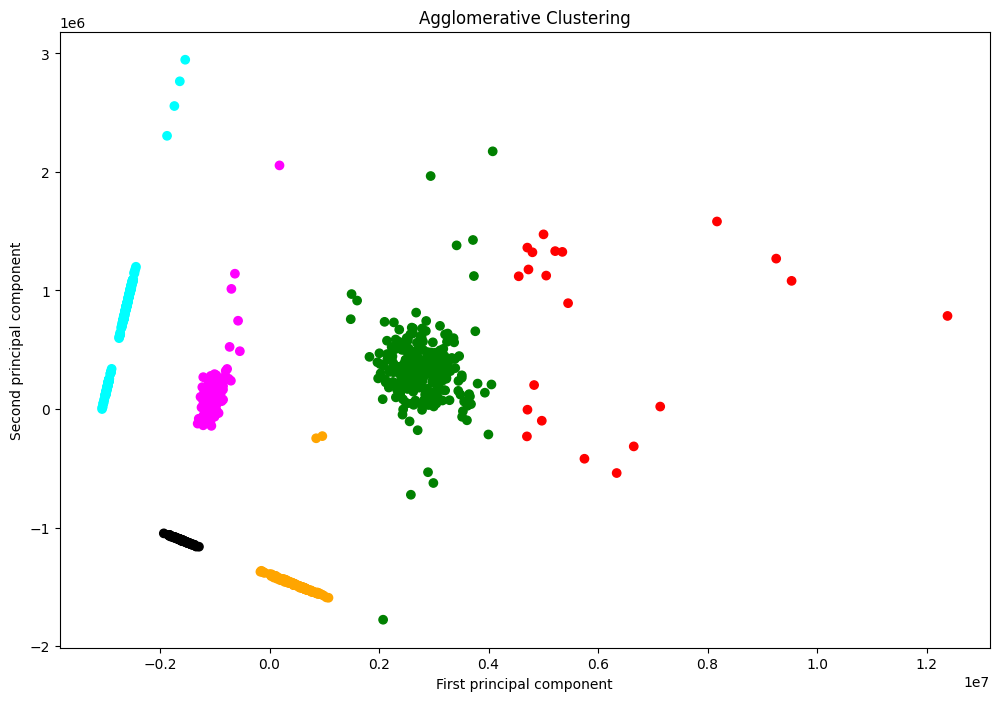

In [618]:
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=[colors[label] for label in labels_[4]],
    cmap="plasma",
)
plt.title("Agglomerative Clustering")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

In [619]:
# apply labels to the original dataset
outlet_info_df["labels"] = labels_[4]

In [620]:
outlet_info_df["labels"].nunique()

6

In [621]:
# write to csv
# outlet_info_df.to_csv('outlet_info_df_with_labels_6.csv', index=False)

In [622]:
from sklearn.cluster import Birch

sil_scores = []
db_scores = []
ch_scores = []
# inertia = []
labels_ = []

for cluster in range(2, 11):
    brc = Birch(n_clusters=cluster).fit(X_reduced_three)
    labels = brc.labels_
    labels_.append(labels)
    # inertia.append(brc.inertia_)
    ch_score = calinski_harabasz_score(X_reduced_three, labels)
    sil_score = silhouette_score(X_reduced_three, labels)
    db_score = davies_bouldin_score(X_reduced_three, labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)

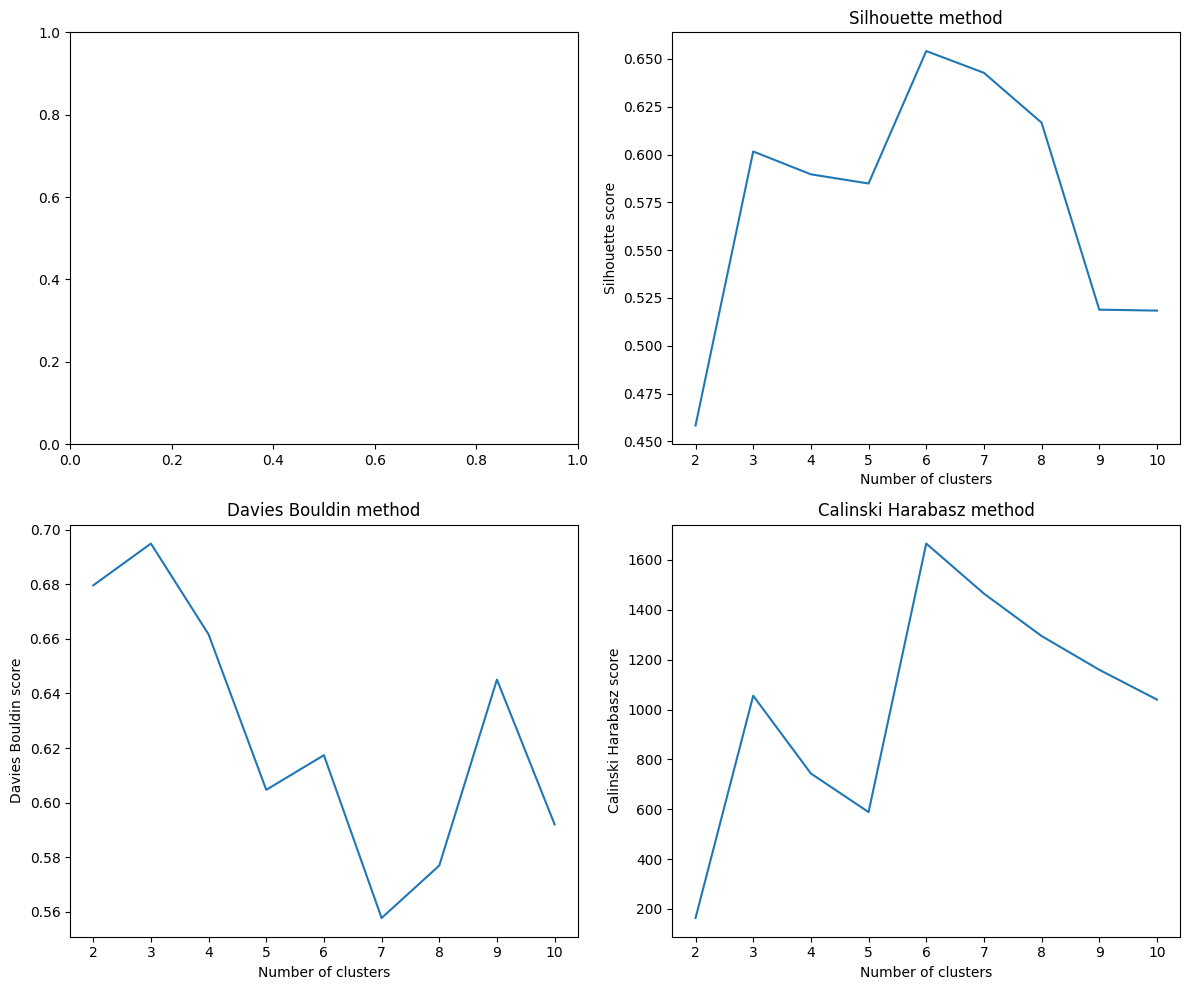

In [623]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

In [624]:
from sklearn.cluster import Birch

sil_scores = []
db_scores = []
ch_scores = []
# inertia = []
labels_ = []

for cluster in range(2, 11):
    brc = Birch(n_clusters=cluster).fit(X_reduced_scaled_standard)
    labels = brc.labels_
    labels_.append(labels)
    # inertia.append(brc.inertia_)
    ch_score = calinski_harabasz_score(X_reduced_scaled_standard, labels)
    sil_score = silhouette_score(X_reduced_scaled_standard, labels)
    db_score = davies_bouldin_score(X_reduced_scaled_standard, labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)

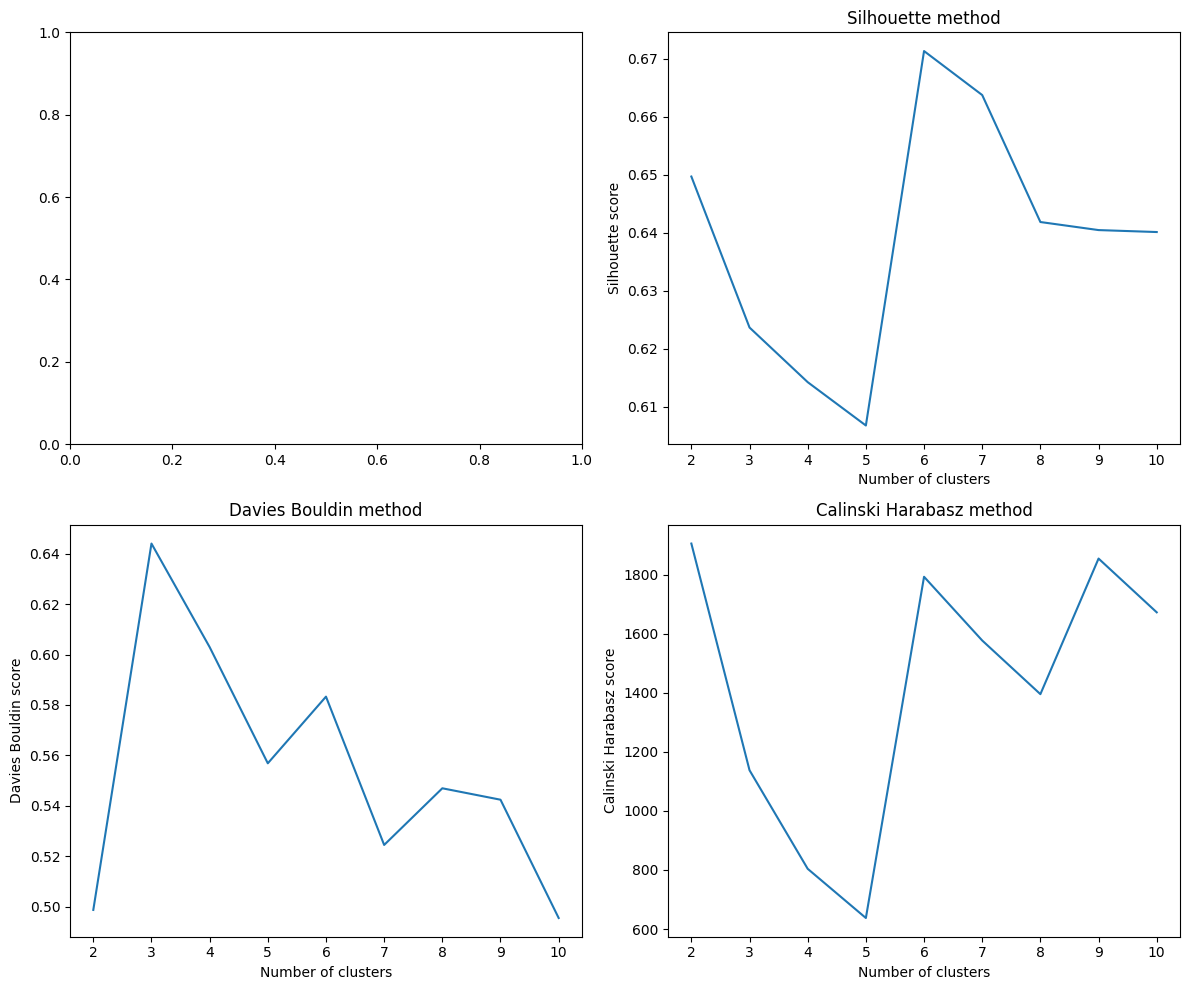

In [625]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

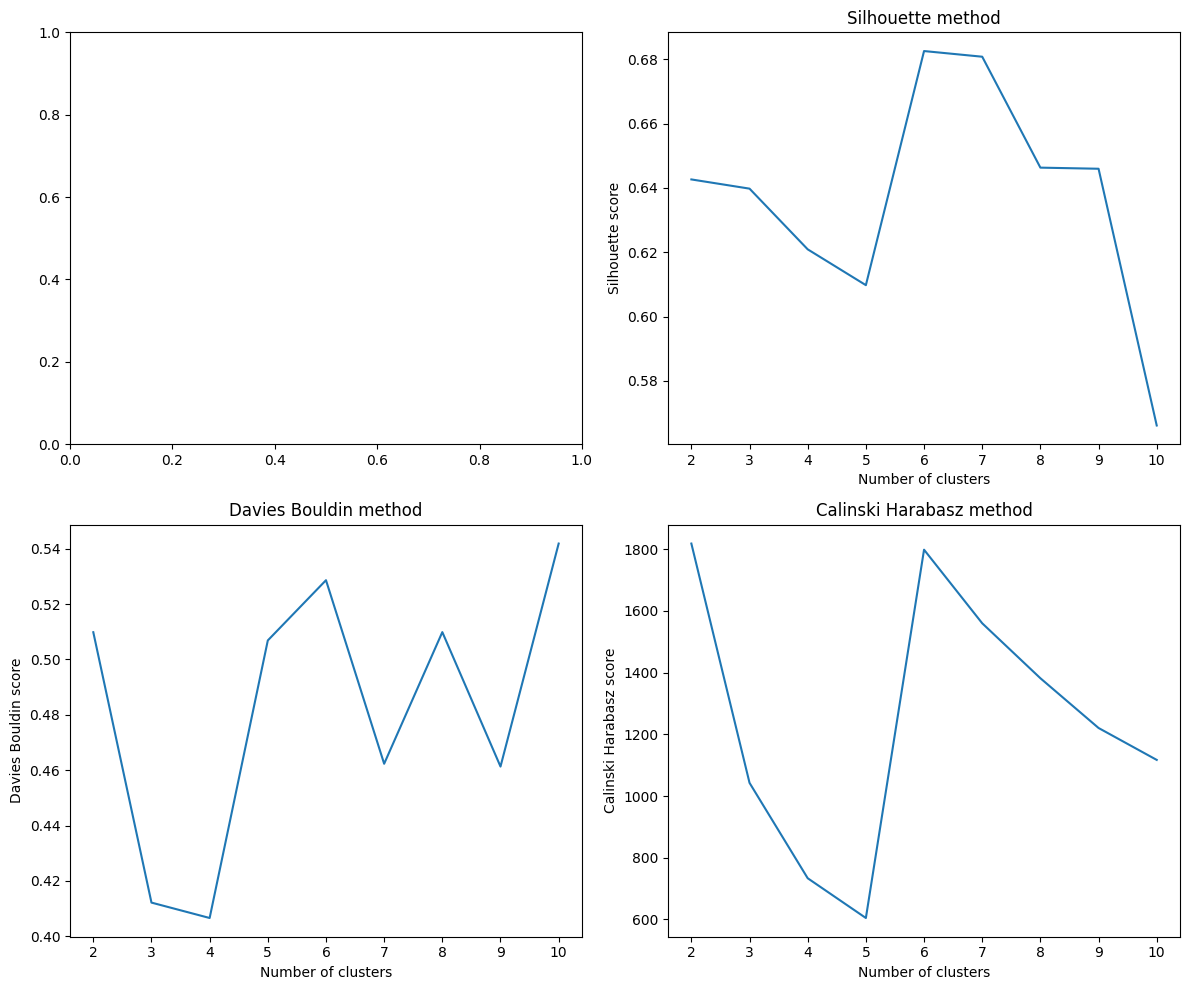

In [626]:
from sklearn.cluster import Birch

sil_scores = []
db_scores = []
ch_scores = []
# inertia = []
labels_ = []

for cluster in range(2, 11):
    brc = Birch(n_clusters=cluster).fit(X_reduced_robust_two)
    labels = brc.labels_
    labels_.append(labels)
    # inertia.append(brc.inertia_)
    ch_score = calinski_harabasz_score(X_reduced_robust_two, labels)
    sil_score = silhouette_score(X_reduced_robust_two, labels)
    db_score = davies_bouldin_score(X_reduced_robust_two, labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

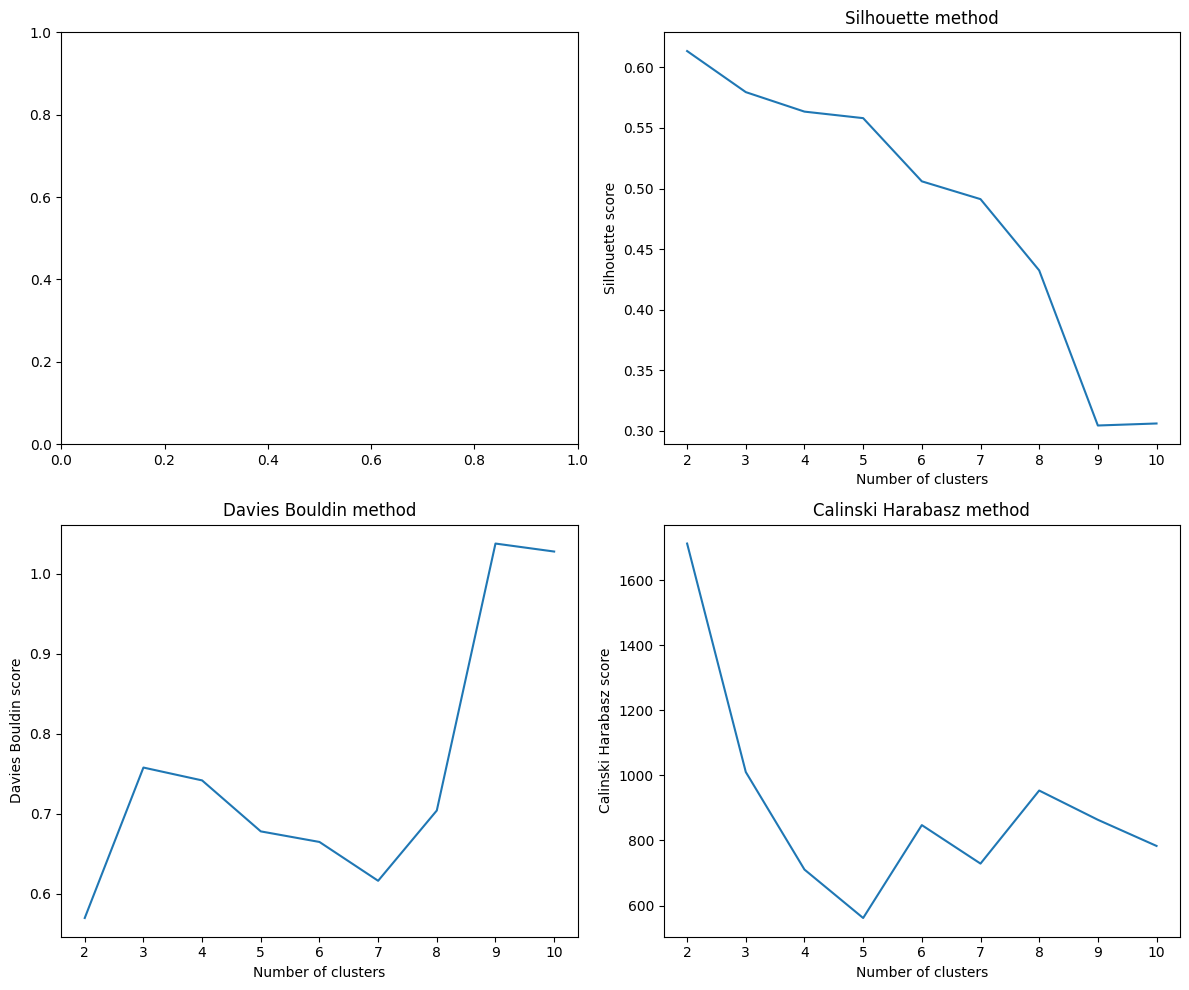

In [627]:
from sklearn.cluster import Birch

sil_scores = []
db_scores = []
ch_scores = []
# inertia = []
labels_ = []

for cluster in range(2, 11):
    brc = Birch(n_clusters=cluster).fit(X_reduced_five)
    labels = brc.labels_
    labels_.append(labels)
    # inertia.append(brc.inertia_)
    ch_score = calinski_harabasz_score(X_reduced_five, labels)
    sil_score = silhouette_score(X_reduced_five, labels)
    db_score = davies_bouldin_score(X_reduced_five, labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Elbow method plot
# axs[0, 0].plot(range(2, 11), inertia)
# axs[0, 0].set_title("Elbow method")
# axs[0, 0].set_xlabel("Number of clusters")
# axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), sil_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

# Some processing

In [628]:
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Chocolate Petite Bar_earning,Mint Bite-size Pop_earning,Strawberry Tiny Cup_earning,Vanilla Mini Cone_earning,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,labels
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,656550.0,552000.0,1003970.0,636100.0,0.0,0.0,0.0,0.0,0.0,2
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,595980.0,795400.0,754160.0,786000.0,0.0,0.0,0.0,0.0,0.0,2
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,730440.0,719200.0,862070.0,762500.0,0.0,0.0,0.0,0.0,0.0,2
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,563310.0,875900.0,1015520.0,653000.0,0.0,0.0,0.0,0.0,0.0,2
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,860580.0,624100.0,841720.0,705700.0,0.0,0.0,0.0,0.0,0.0,2


In [629]:
sales_data_df.head()

,Outlet_ID,week,pid,product_name,no_units,price,volume,Start Date,End Date,month_of_transaction,total_earning,total_volume_sold
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,100,0.2,2023-01-02,2023-01-08,1,87400.0,174.8
1,ID7203,1,IP2,Chocolate Petite Bar,105.0,90,0.2,2023-01-02,2023-01-08,1,9450.0,21.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0,110,0.2,2023-01-02,2023-01-08,1,131780.0,239.6
3,ID7203,1,IP4,Mint Bite-size Pop,502.0,100,0.2,2023-01-02,2023-01-08,1,50200.0,100.4
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0,100,0.2,2023-01-02,2023-01-08,1,71000.0,142.0


In [630]:
# group by Outlet_ID and week get the sum of sales
weekly_earn_df = (
    sales_data_df.groupby(["Outlet_ID", "week"])["total_earning"].sum().reset_index()
)
weekly_earn_df = (
    weekly_earn_df.groupby(["Outlet_ID"])["total_earning"].mean().reset_index()
)
weekly_earn_df.head()

,Outlet_ID,total_earning
0,ID1008,2.742492e+05
1,ID1012,3.040542e+05
2,ID1024,6.438583e+05
3,ID1029,1.116763e+06
4,ID1036,5.282392e+05


In [631]:
# rename the column to mean_weekly_earning
weekly_earn_df.rename(columns={"total_earning": "mean_weekly_earning"}, inplace=True)
weekly_earn_df.head()

,Outlet_ID,mean_weekly_earning
0,ID1008,2.742492e+05
1,ID1012,3.040542e+05
2,ID1024,6.438583e+05
3,ID1029,1.116763e+06
4,ID1036,5.282392e+05


In [632]:
# merge with outlet_info_df
outlet_info_df = pd.merge(outlet_info_df, weekly_earn_df, on="Outlet_ID", how="left")
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Mint Bite-size Pop_earning,Strawberry Tiny Cup_earning,Vanilla Mini Cone_earning,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,labels,mean_weekly_earning
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,552000.0,1003970.0,636100.0,0.0,0.0,0.0,0.0,0.0,2,291076.666667
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,795400.0,754160.0,786000.0,0.0,0.0,0.0,0.0,0.0,2,300528.333333
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,719200.0,862070.0,762500.0,0.0,0.0,0.0,0.0,0.0,2,312992.500000
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,875900.0,1015520.0,653000.0,0.0,0.0,0.0,0.0,0.0,2,338344.166667
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,624100.0,841720.0,705700.0,0.0,0.0,0.0,0.0,0.0,2,326558.333333


In [633]:
weekly_units_df = (
    sales_data_df.groupby(["Outlet_ID", "week"])["no_units"].sum().reset_index()
)
weekly_units_df = (
    weekly_units_df.groupby(["Outlet_ID"])["no_units"].mean().reset_index()
)

weekly_units_df.rename(columns={"no_units": "mean_weekly_units_sold"}, inplace=True)

outlet_info_df = pd.merge(outlet_info_df, weekly_units_df, on="Outlet_ID", how="left")
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Strawberry Tiny Cup_earning,Vanilla Mini Cone_earning,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,labels,mean_weekly_earning,mean_weekly_units_sold
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,1003970.0,636100.0,0.0,0.0,0.0,0.0,0.0,2,291076.666667,2895.500000
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,754160.0,786000.0,0.0,0.0,0.0,0.0,0.0,2,300528.333333,3003.333333
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,862070.0,762500.0,0.0,0.0,0.0,0.0,0.0,2,312992.500000,3132.250000
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,1015520.0,653000.0,0.0,0.0,0.0,0.0,0.0,2,338344.166667,3358.666667
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,841720.0,705700.0,0.0,0.0,0.0,0.0,0.0,2,326558.333333,3281.500000


In [634]:
weekly_vol_df = (
    sales_data_df.groupby(["Outlet_ID", "week"])["total_volume_sold"]
    .sum()
    .reset_index()
)
weekly_vol_df = (
    weekly_vol_df.groupby(["Outlet_ID"])["total_volume_sold"].mean().reset_index()
)

weekly_vol_df.rename(
    columns={"total_volume_sold": "mean_weekly_volume_sold"}, inplace=True
)

outlet_info_df = pd.merge(outlet_info_df, weekly_vol_df, on="Outlet_ID", how="left")
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Vanilla Mini Cone_earning,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,labels,mean_weekly_earning,mean_weekly_units_sold,mean_weekly_volume_sold
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,636100.0,0.0,0.0,0.0,0.0,0.0,2,291076.666667,2895.500000,579.100000
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,786000.0,0.0,0.0,0.0,0.0,0.0,2,300528.333333,3003.333333,600.666667
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,762500.0,0.0,0.0,0.0,0.0,0.0,2,312992.500000,3132.250000,626.450000
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,653000.0,0.0,0.0,0.0,0.0,0.0,2,338344.166667,3358.666667,671.733333
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,705700.0,0.0,0.0,0.0,0.0,0.0,2,326558.333333,3281.500000,656.300000


In [635]:
outlet_info_df = outlet_info_df.merge(outlets_area_df, on="Outlet_ID", how="left")
outlet_info_df.head()

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,labels,mean_weekly_earning,mean_weekly_units_sold,mean_weekly_volume_sold,area(sqft)
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,0.0,0.0,0.0,0.0,0.0,2,291076.666667,2895.500000,579.100000,5660
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,0.0,0.0,0.0,0.0,0.0,2,300528.333333,3003.333333,600.666667,4138
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,0.0,0.0,0.0,0.0,0.0,2,312992.500000,3132.250000,626.450000,5546
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,0.0,0.0,0.0,0.0,0.0,2,338344.166667,3358.666667,671.733333,5134
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,0.0,0.0,0.0,0.0,0.0,2,326558.333333,3281.500000,656.300000,4100


# Freezer Allocation

In [637]:
freezer_data = pd.read_csv("./dataset/freezer_data.csv")

freezer_volume_dict = dict(zip(freezer_data['Model Number'], freezer_data['Volume Capacity (Liters)']))
freezer_cost_dict = dict(zip(freezer_data['Model Number'], freezer_data['Power and maitainance Cost (LKR) per 100 hours']))

In [638]:
def ceildiv(a, b):
    return -(-a // b)

In [639]:
outlet_info_df

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,labels,mean_weekly_earning,mean_weekly_units_sold,mean_weekly_volume_sold,area(sqft)
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,0.0,0.0,0.0,0.0,0.0,2,291076.666667,2895.500000,579.100000,5660
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,0.0,0.0,0.0,0.0,0.0,2,300528.333333,3003.333333,600.666667,4138
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,0.0,0.0,0.0,0.0,0.0,2,312992.500000,3132.250000,626.450000,5546
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,0.0,0.0,0.0,0.0,0.0,2,338344.166667,3358.666667,671.733333,5134
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,0.0,0.0,0.0,0.0,0.0,2,326558.333333,3281.500000,656.300000,4100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,ID4119,2436.0,2616.0,1920.0,2025.0,3133.0,2046.0,1998.0,1909.0,2352.0,...,748800.0,630300.0,725650.0,558800.0,602000.0,4,469293.333333,2226.083333,641.083333,3858
947,ID2978,2969.0,2079.0,1688.0,2879.0,996.0,3063.0,2525.0,2007.0,1786.0,...,760800.0,746900.0,753250.0,553300.0,682000.0,4,495224.166667,2307.916667,671.783333,3495
948,ID6549,2441.0,2798.0,2446.0,2988.0,3001.0,2743.0,2085.0,2838.0,1903.0,...,890400.0,597300.0,778550.0,672100.0,716000.0,4,534135.833333,2581.166667,735.500000,1141
949,ID1210,2725.0,3084.0,2402.0,3856.0,1667.0,1378.0,2873.0,1994.0,3625.0,...,622800.0,744700.0,763600.0,585200.0,608000.0,4,506050.000000,2552.833333,710.566667,3322


In [640]:
outlets_data_labeled= outlet_info_df.groupby("labels")[["mean_weekly_earning", "mean_weekly_volume_sold"]].mean().reset_index()

In [641]:
outlets_data_labeled

,labels,mean_weekly_earning,mean_weekly_volume_sold
0,0,1.802186e+06,2189.207143
1,1,1.184406e+06,1463.347400
2,2,2.602468e+05,520.402482
3,3,6.264267e+05,567.806743
4,4,5.034180e+05,691.522769
5,5,2.964476e+05,267.188552


In [642]:
outlets_data_labeled_ = outlets_data_labeled.copy()
for f_id, f_cap in freezer_volume_dict.items():
    outlets_data_labeled_[f"{f_id}s_needed"] = ceildiv(outlets_data_labeled_["mean_weekly_volume_sold"], f_cap)
    outlets_data_labeled_[f"{f_id}s_cost"] = outlets_data_labeled_[f"{f_id}s_needed"] * freezer_cost_dict[f_id]

outlets_data_labeled_

,labels,mean_weekly_earning,mean_weekly_volume_sold,M001s_needed,M001s_cost,M002s_needed,M002s_cost,M003s_needed,M003s_cost,M004s_needed,...,M006s_needed,M006s_cost,M007s_needed,M007s_cost,M008s_needed,M008s_cost,M009s_needed,M009s_cost,M010s_needed,M010s_cost
0,0,1.802186e+06,2189.207143,40.0,100000.0,30.0,84000.0,19.0,60800.0,73.0,...,34.0,91800.0,22.0,66000.0,88.0,140800.0,28.0,78400.0,11.0,49500.0
1,1,1.184406e+06,1463.347400,27.0,67500.0,20.0,56000.0,13.0,41600.0,49.0,...,23.0,62100.0,15.0,45000.0,59.0,94400.0,19.0,53200.0,8.0,36000.0
2,2,2.602468e+05,520.402482,10.0,25000.0,7.0,19600.0,5.0,16000.0,18.0,...,9.0,24300.0,6.0,18000.0,21.0,33600.0,7.0,19600.0,3.0,13500.0
3,3,6.264267e+05,567.806743,11.0,27500.0,8.0,22400.0,5.0,16000.0,19.0,...,9.0,24300.0,6.0,18000.0,23.0,36800.0,8.0,22400.0,3.0,13500.0
4,4,5.034180e+05,691.522769,13.0,32500.0,10.0,28000.0,6.0,19200.0,24.0,...,11.0,29700.0,7.0,21000.0,28.0,44800.0,9.0,25200.0,4.0,18000.0
5,5,2.964476e+05,267.188552,5.0,12500.0,4.0,11200.0,3.0,9600.0,9.0,...,5.0,13500.0,3.0,9000.0,11.0,17600.0,4.0,11200.0,2.0,9000.0


In [643]:
def get_min_cost(row):
    freezer_ids = list(freezer_volume_dict.keys())
    freezer_ids.sort()
    min = np.inf
    for f_id in freezer_ids:
        if row[f"{f_id}s_cost"] < min:
            min = row[f"{f_id}s_cost"]
           
    
    return min

def get_min_fid(row):
    freezer_ids = list(freezer_volume_dict.keys())
    freezer_ids.sort()
    min = np.inf
    min_f_id = ""
    for f_id in freezer_ids:
        if row[f"{f_id}s_cost"] < min:
            min = row[f"{f_id}s_cost"]
            min_f_id = f_id
    
    return min_f_id

In [644]:
outlets_data_labeled_["min_fridge_cost"] = outlets_data_labeled_.apply(get_min_cost, axis=1)
outlets_data_labeled_["min_fridge_id"] = outlets_data_labeled_.apply(get_min_fid, axis=1)

outlets_data_labeled_

,labels,mean_weekly_earning,mean_weekly_volume_sold,M001s_needed,M001s_cost,M002s_needed,M002s_cost,M003s_needed,M003s_cost,M004s_needed,...,M007s_needed,M007s_cost,M008s_needed,M008s_cost,M009s_needed,M009s_cost,M010s_needed,M010s_cost,min_fridge_cost,min_fridge_id
0,0,1.802186e+06,2189.207143,40.0,100000.0,30.0,84000.0,19.0,60800.0,73.0,...,22.0,66000.0,88.0,140800.0,28.0,78400.0,11.0,49500.0,49500.0,M010
1,1,1.184406e+06,1463.347400,27.0,67500.0,20.0,56000.0,13.0,41600.0,49.0,...,15.0,45000.0,59.0,94400.0,19.0,53200.0,8.0,36000.0,35000.0,M005
2,2,2.602468e+05,520.402482,10.0,25000.0,7.0,19600.0,5.0,16000.0,18.0,...,6.0,18000.0,21.0,33600.0,7.0,19600.0,3.0,13500.0,13500.0,M010
3,3,6.264267e+05,567.806743,11.0,27500.0,8.0,22400.0,5.0,16000.0,19.0,...,6.0,18000.0,23.0,36800.0,8.0,22400.0,3.0,13500.0,13500.0,M010
4,4,5.034180e+05,691.522769,13.0,32500.0,10.0,28000.0,6.0,19200.0,24.0,...,7.0,21000.0,28.0,44800.0,9.0,25200.0,4.0,18000.0,17500.0,M005
5,5,2.964476e+05,267.188552,5.0,12500.0,4.0,11200.0,3.0,9600.0,9.0,...,3.0,9000.0,11.0,17600.0,4.0,11200.0,2.0,9000.0,7000.0,M005


In [645]:
outlets_data_falloc = outlets_data_labeled_[
    [
        "labels",
        "min_fridge_id",
        "min_fridge_cost",
        "mean_weekly_volume_sold",
        "mean_weekly_earning",
    ]
].copy()

In [646]:
outlets_data_falloc["nfridges"] = outlets_data_falloc.apply(lambda row: row["min_fridge_cost"]/freezer_cost_dict[row["min_fridge_id"]], axis=1)
outlets_data_falloc['tot_freezer_capacity'] = outlets_data_falloc.apply(lambda row: row["nfridges"]*freezer_volume_dict[row["min_fridge_id"]], axis=1)

outlets_data_falloc

,labels,min_fridge_id,min_fridge_cost,mean_weekly_volume_sold,mean_weekly_earning,nfridges,tot_freezer_capacity
0,0,M010,49500.0,2189.207143,1.802186e+06,11.0,2200.0
1,1,M005,35000.0,1463.347400,1.184406e+06,10.0,1500.0
2,2,M010,13500.0,520.402482,2.602468e+05,3.0,600.0
3,3,M010,13500.0,567.806743,6.264267e+05,3.0,600.0
4,4,M005,17500.0,691.522769,5.034180e+05,5.0,750.0
5,5,M005,7000.0,267.188552,2.964476e+05,2.0,300.0


In [647]:
outlets_data_falloc["ROI"] = outlets_data_falloc["mean_weekly_earning"] / outlets_data_falloc["min_fridge_cost"]
outlets_data_falloc["item_sales_ratio"] = outlets_data_falloc["mean_weekly_volume_sold"] / outlets_data_falloc["tot_freezer_capacity"]

In [648]:
outlets_data_falloc

,labels,min_fridge_id,min_fridge_cost,mean_weekly_volume_sold,mean_weekly_earning,nfridges,tot_freezer_capacity,ROI,item_sales_ratio
0,0,M010,49500.0,2189.207143,1.802186e+06,11.0,2200.0,36.407799,0.995094
1,1,M005,35000.0,1463.347400,1.184406e+06,10.0,1500.0,33.840166,0.975565
2,2,M010,13500.0,520.402482,2.602468e+05,3.0,600.0,19.277538,0.867337
3,3,M010,13500.0,567.806743,6.264267e+05,3.0,600.0,46.401977,0.946345
4,4,M005,17500.0,691.522769,5.034180e+05,5.0,750.0,28.766742,0.922030
5,5,M005,7000.0,267.188552,2.964476e+05,2.0,300.0,42.349651,0.890629


## Fridge Allocation for Autoencoder with KMeans

In [649]:
sandil2_df = pd.read_csv("./encoded_outlets.csv")

In [650]:
outlet_info_df

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,labels,mean_weekly_earning,mean_weekly_units_sold,mean_weekly_volume_sold,area(sqft)
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,0.0,0.0,0.0,0.0,0.0,2,291076.666667,2895.500000,579.100000,5660
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,0.0,0.0,0.0,0.0,0.0,2,300528.333333,3003.333333,600.666667,4138
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,0.0,0.0,0.0,0.0,0.0,2,312992.500000,3132.250000,626.450000,5546
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,0.0,0.0,0.0,0.0,0.0,2,338344.166667,3358.666667,671.733333,5134
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,0.0,0.0,0.0,0.0,0.0,2,326558.333333,3281.500000,656.300000,4100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,ID4119,2436.0,2616.0,1920.0,2025.0,3133.0,2046.0,1998.0,1909.0,2352.0,...,748800.0,630300.0,725650.0,558800.0,602000.0,4,469293.333333,2226.083333,641.083333,3858
947,ID2978,2969.0,2079.0,1688.0,2879.0,996.0,3063.0,2525.0,2007.0,1786.0,...,760800.0,746900.0,753250.0,553300.0,682000.0,4,495224.166667,2307.916667,671.783333,3495
948,ID6549,2441.0,2798.0,2446.0,2988.0,3001.0,2743.0,2085.0,2838.0,1903.0,...,890400.0,597300.0,778550.0,672100.0,716000.0,4,534135.833333,2581.166667,735.500000,1141
949,ID1210,2725.0,3084.0,2402.0,3856.0,1667.0,1378.0,2873.0,1994.0,3625.0,...,622800.0,744700.0,763600.0,585200.0,608000.0,4,506050.000000,2552.833333,710.566667,3322


In [651]:
outlet_info_df_ = outlet_info_df.drop(columns=["labels"]).merge(sandil2_df[["Outlet_ID", "cluster"]], on="Outlet_ID", how="left").copy()

In [652]:
outlet_info_df_

,Outlet_ID,weekly_sale_for_1,weekly_sale_for_2,weekly_sale_for_3,weekly_sale_for_4,weekly_sale_for_5,weekly_sale_for_6,weekly_sale_for_7,weekly_sale_for_8,weekly_sale_for_9,...,Chocolate Fudge Big Scoop_earning,Cookies and Cream Mega Tub_earning,Mint Chocolate Chip Family Pack_earning,Moose Tracks Jumbo Cup_earning,Rocky Road Mega Tub_earning,mean_weekly_earning,mean_weekly_units_sold,mean_weekly_volume_sold,area(sqft),cluster
0,ID7203,3389.0,2402.0,2805.0,2583.0,2802.0,3227.0,2992.0,3138.0,2309.0,...,0.0,0.0,0.0,0.0,0.0,291076.666667,2895.500000,579.100000,5660,2
1,ID1878,2597.0,2048.0,2809.0,3724.0,3213.0,3313.0,2883.0,3501.0,3312.0,...,0.0,0.0,0.0,0.0,0.0,300528.333333,3003.333333,600.666667,4138,2
2,ID1740,3742.0,3208.0,3702.0,3060.0,3822.0,3190.0,2138.0,2812.0,2072.0,...,0.0,0.0,0.0,0.0,0.0,312992.500000,3132.250000,626.450000,5546,2
3,ID4366,3410.0,3072.0,3843.0,4036.0,2328.0,2454.0,3181.0,3025.0,3975.0,...,0.0,0.0,0.0,0.0,0.0,338344.166667,3358.666667,671.733333,5134,2
4,ID8358,2891.0,4185.0,3433.0,4552.0,1080.0,3598.0,3164.0,3497.0,3738.0,...,0.0,0.0,0.0,0.0,0.0,326558.333333,3281.500000,656.300000,4100,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,ID4119,2436.0,2616.0,1920.0,2025.0,3133.0,2046.0,1998.0,1909.0,2352.0,...,748800.0,630300.0,725650.0,558800.0,602000.0,469293.333333,2226.083333,641.083333,3858,2
984,ID2978,2969.0,2079.0,1688.0,2879.0,996.0,3063.0,2525.0,2007.0,1786.0,...,760800.0,746900.0,753250.0,553300.0,682000.0,495224.166667,2307.916667,671.783333,3495,2
985,ID6549,2441.0,2798.0,2446.0,2988.0,3001.0,2743.0,2085.0,2838.0,1903.0,...,890400.0,597300.0,778550.0,672100.0,716000.0,534135.833333,2581.166667,735.500000,1141,2
986,ID1210,2725.0,3084.0,2402.0,3856.0,1667.0,1378.0,2873.0,1994.0,3625.0,...,622800.0,744700.0,763600.0,585200.0,608000.0,506050.000000,2552.833333,710.566667,3322,2


In [653]:
outlets_data_labeled= outlet_info_df_.groupby("cluster")[["mean_weekly_earning", "mean_weekly_volume_sold"]].mean().reset_index()

In [654]:
outlets_data_labeled_ = outlets_data_labeled.copy()
for f_id, f_cap in freezer_volume_dict.items():
    outlets_data_labeled_[f"{f_id}s_needed"] = ceildiv(outlets_data_labeled_["mean_weekly_volume_sold"], f_cap)
    outlets_data_labeled_[f"{f_id}s_cost"] = outlets_data_labeled_[f"{f_id}s_needed"] * freezer_cost_dict[f_id]

outlets_data_labeled_

,cluster,mean_weekly_earning,mean_weekly_volume_sold,M001s_needed,M001s_cost,M002s_needed,M002s_cost,M003s_needed,M003s_cost,M004s_needed,...,M006s_needed,M006s_cost,M007s_needed,M007s_cost,M008s_needed,M008s_cost,M009s_needed,M009s_cost,M010s_needed,M010s_cost
0,0,1.187665e+06,1469.319955,27.0,67500.0,20.0,56000.0,13.0,41600.0,49.0,...,23.0,62100.0,15.0,45000.0,59.0,94400.0,19.0,53200.0,8.0,36000.0
1,1,4.849972e+05,436.892391,8.0,20000.0,6.0,16800.0,4.0,12800.0,15.0,...,7.0,18900.0,5.0,15000.0,18.0,28800.0,6.0,16800.0,3.0,13500.0
2,2,3.760313e+05,598.912539,11.0,27500.0,8.0,22400.0,5.0,16000.0,20.0,...,10.0,27000.0,6.0,18000.0,24.0,38400.0,8.0,22400.0,3.0,13500.0
3,3,1.742291e+06,2207.246190,41.0,102500.0,30.0,84000.0,19.0,60800.0,74.0,...,34.0,91800.0,23.0,69000.0,89.0,142400.0,28.0,78400.0,12.0,54000.0


In [655]:
outlets_data_labeled_["min_fridge_cost"] = outlets_data_labeled_.apply(get_min_cost, axis=1)
outlets_data_labeled_["min_fridge_id"] = outlets_data_labeled_.apply(get_min_fid, axis=1)

outlets_data_labeled_

,cluster,mean_weekly_earning,mean_weekly_volume_sold,M001s_needed,M001s_cost,M002s_needed,M002s_cost,M003s_needed,M003s_cost,M004s_needed,...,M007s_needed,M007s_cost,M008s_needed,M008s_cost,M009s_needed,M009s_cost,M010s_needed,M010s_cost,min_fridge_cost,min_fridge_id
0,0,1.187665e+06,1469.319955,27.0,67500.0,20.0,56000.0,13.0,41600.0,49.0,...,15.0,45000.0,59.0,94400.0,19.0,53200.0,8.0,36000.0,35000.0,M005
1,1,4.849972e+05,436.892391,8.0,20000.0,6.0,16800.0,4.0,12800.0,15.0,...,5.0,15000.0,18.0,28800.0,6.0,16800.0,3.0,13500.0,10500.0,M005
2,2,3.760313e+05,598.912539,11.0,27500.0,8.0,22400.0,5.0,16000.0,20.0,...,6.0,18000.0,24.0,38400.0,8.0,22400.0,3.0,13500.0,13500.0,M010
3,3,1.742291e+06,2207.246190,41.0,102500.0,30.0,84000.0,19.0,60800.0,74.0,...,23.0,69000.0,89.0,142400.0,28.0,78400.0,12.0,54000.0,52500.0,M005


In [657]:
outlets_data_falloc = outlets_data_labeled_[
    [
        "cluster",
        "min_fridge_id",
        "min_fridge_cost",
        "mean_weekly_volume_sold",
        "mean_weekly_earning",
    ]
].copy()

In [658]:
outlets_data_falloc["nfridges"] = outlets_data_falloc.apply(lambda row: row["min_fridge_cost"]/freezer_cost_dict[row["min_fridge_id"]], axis=1)
outlets_data_falloc['tot_freezer_capacity'] = outlets_data_falloc.apply(lambda row: row["nfridges"]*freezer_volume_dict[row["min_fridge_id"]], axis=1)

outlets_data_falloc

,cluster,min_fridge_id,min_fridge_cost,mean_weekly_volume_sold,mean_weekly_earning,nfridges,tot_freezer_capacity
0,0,M005,35000.0,1469.319955,1.187665e+06,10.0,1500.0
1,1,M005,10500.0,436.892391,4.849972e+05,3.0,450.0
2,2,M010,13500.0,598.912539,3.760313e+05,3.0,600.0
3,3,M005,52500.0,2207.246190,1.742291e+06,15.0,2250.0


In [659]:
outlets_data_falloc["ROI"] = outlets_data_falloc["mean_weekly_earning"] / outlets_data_falloc["min_fridge_cost"]
outlets_data_falloc["item_sales_ratio"] = outlets_data_falloc["mean_weekly_volume_sold"] / outlets_data_falloc["tot_freezer_capacity"]

In [660]:
outlets_data_falloc

,cluster,min_fridge_id,min_fridge_cost,mean_weekly_volume_sold,mean_weekly_earning,nfridges,tot_freezer_capacity,ROI,item_sales_ratio
0,0,M005,35000.0,1469.319955,1.187665e+06,10.0,1500.0,33.933294,0.979547
1,1,M005,10500.0,436.892391,4.849972e+05,3.0,450.0,46.190210,0.970872
2,2,M010,13500.0,598.912539,3.760313e+05,3.0,600.0,27.854170,0.998188
3,3,M005,52500.0,2207.246190,1.742291e+06,15.0,2250.0,33.186500,0.980998


# Finding patterns for each segment

In [ ]:
outlet_info_df.columns

In [ ]:
outlet_info_df.head()

In [ ]:
# plot graph mean_weekly_earning vs labels
plt.figure(figsize=(10, 8))
sns.scatterplot(outlet_info_df, x='mean_weekly_earning', y='labels')

In [ ]:
# plot graph mean_weekly_earning vs labels
plt.figure(figsize=(10, 8))
sns.scatterplot(outlet_info_df, x='Butter Pecan Small Stick_units_sold', y='labels')